In [7]:
import json

import pyleoclim as pyleo
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so


from pylipd.lipd import LiPD
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch


## FROM KRL: Also import matplotlib.pyplot for additional figure-making capabilities
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import ticker

plt.rcParams['pdf.fonttype'] = 42  # changes font type so that vector graphics software (i.e. Adobe Illustrator) recognizes text
plt.rcParams['font.family'] = "Arial"  # changes font type to Arial; Illustrator on Windows doesn't work well with default Pyplot font

In [8]:
#import data
# lipidData = pd.read_csv('/Users/elizabeth/Library/CloudStorage/Box-Box/gly-ekthomas/gly-ekthomas-projects/UB Paleoclimate Group/Thomas Group Research projects/Scandinavia/20240814_NCO Scandinavia FAME_Data.csv')
# lipidData

# Ensemble Series creation function

Here we define the function we'll use to create ensembles. We'll require that the user pass in a vector for paleo data values, a vector for depth related to the paleo data, an ensemble table, and a vector for depth related to the ensemble table. The first dimension of the paleo data values and the first dimension of the paleo depth vector should be the same. The same goes for the age ensemble depth vector and the age ensemble matrix. Feel free to copy and use this function at will!

In [9]:
def mapAgeEnsembleToPaleoData(ensembleValues, paleoValues, ensembleDepth, paleoDepth,
                             value_name = None,value_unit = None,time_name = None,time_unit = None):
    """ Map the depth for the ensemble age values to the paleo values

    Parameters
    ----------

    ensembleValues : array
        A matrix of possible age models. Realizations
        should be stored in columns
        
    paleoValues : 1D array
        A vector containing the paleo data values. The vector
        should have the same length as depthPaleo
        
    ensembleDepth : 1D array
        A vector of depth. The vector should have the same
        length as the number of rows in the ensembleValues
        
    paleoDepth : 1D array
        A vector corresponding to the depth at which there
        are paleodata information
        
    value_name : str
        Paleo data value name
    
    value_unit : str
        Paleo data value unit
    
    time_name : str
        Time name
    
    time_unit : str
        Time unit

    Returns
    -------

    ensemble : pyleoclim.EnsembleSeries
        A matrix of age ensemble on the PaleoData scale

    """

    #Make sure that numpy arrays were given and try to coerce them into vectors if possible
    ensembleDepth=np.squeeze(np.array(ensembleDepth))
    paleoValues = np.squeeze(np.array(paleoValues))
    paleoDepth = np.squeeze(np.array(paleoDepth))

    #Check that arrays are vectors for np.interp
    if paleoValues.ndim > 1:
        raise ValueError('ensembleValues has more than one dimension, please pass it as a 1D array')
    if ensembleDepth.ndim > 1:
        raise ValueError('ensembleDepth has more than one dimension, please pass it as a 1D array')
    if paleoDepth.ndim > 1:
        raise ValueError('paleoDepth has more than one dimension, please pass it as a 1D array')

    if len(ensembleDepth)!=np.shape(ensembleValues)[0]:
        raise ValueError("Ensemble depth and age need to have the same length")
        
    if len(paleoValues) != len(paleoDepth):
        raise ValueError("Paleo depth and age need to have the same length")

    #Interpolate
    ensembleValuesToPaleo = np.zeros((len(paleoDepth),np.shape(ensembleValues)[1])) #placeholder
    
    for i in np.arange(0,np.shape(ensembleValues)[1]):
        ensembleValuesToPaleo[:,i]=np.interp(paleoDepth,ensembleDepth,ensembleValues[:,i])
    
    series_list = []
    
    for s in ensembleValuesToPaleo.T:
        series_tmp = pyleo.Series(time=s, value=paleoValues,
                       verbose=False,
                       clean_ts=False,
                       value_name=value_name,
                       value_unit=value_unit,
                       time_name=time_name,
                       time_unit=time_unit)
        series_list.append(series_tmp)
    
    ensemble = pyleo.EnsembleSeries(series_list=series_list)

    return ensemble

## Define function 'getlipd()' for importing LiPD data

# Arguments + Keyword Arguments:
# filename = name of LiPD file
# paleoData_variableName = column name of variable being imported
# depth_name = column name of depth variable (for using depths in multiple paleoData tables)
# val_unit = unit of the paleoData variable being imported
# ens_num = index of paleo data table containing the imported variable, set to 0 by default

# Function returns:
# ensemble = LiPD age ensemble mapped to selected paleoData returned by the
# 'mapAgeEnsembleToPaleoData()' function used within 'getlipd()'

# age_axis = pandas dataframe containing columns of the selected paleoData depth, median age values, and paleoData values
# Makes it easier to work with LiPD data and make plots that don't need the age ensemble information

# KRL Notes:
# I haven't fully tested what happens when you have multiple paleoData tables with the depth column named 'depth'
# Not sure if that could lead to the wrong depth resolution being exported relative to the paleoData
# My larger LiPD files use different names for the depth column in each table; i.e 'geotekDepth', 'itraxDepth'

# I'm also not entirely sure how the indexing of ensemble df works. In the Pyleoclim tutorial,
# indexing the column of 'ensemble_df' for variables like 'ensembleDepth' always use 
# 'ensemble_df.iloc[0]. Leaving 'ens_num=0' seems to work no matter how many paleoData tables I have in a single
# LiPD file. Perhaps it matters when there are multiple 'depth' columns. 

def getlipd(filename,
            paleoData_variableName,
            depth_name,
            val_unit,
            ens_num=0):

    D = LiPD()
    D.load(filename)

    ensemble_df = D.get_ensemble_tables()
    pd.set_option('display.max_columns', None)
    print(ensemble_df)

    timeseries, df = D.get_timeseries(D.get_all_dataset_names(), to_dataframe=True)
    # print(df)
    # print(df.columns)
    df['paleoData_variableName'].unique()

    df_row = df.loc[df['paleoData_variableName']==paleoData_variableName]
    paleoDepth = np.array(*df_row[depth_name])
    paleoAgeMedian = np.array(*df_row['ageMedian'])
    paleoValues = np.array(*df_row['paleoData_values'])
    # paleo_depth_units = df_row['depthUnits']
    value_name = paleoData_variableName
    value_unit = val_unit
    ensembleDepth = ensemble_df.iloc[ens_num]['ensembleDepthValues']
    ensembleValues = ensemble_df.iloc[ens_num]['ensembleVariableValues']
    ensemble_depth_units = ensemble_df.iloc[ens_num]['ensembleDepthUnits']
    time_name = 'Time'
    time_unit = f'{ensemble_df.iloc[ens_num]["ensembleVariableName"]} {ensemble_df.iloc[ens_num]["ensembleVariableUnits"]}'
    # print(type(ensembleValues))
    # print(ensembleValues)
    # print(ensembleDepth)
    # print(paleoValues)
    # print(f'Num rows in ensembleValues: {ensembleValues.shape[0]}, Length of ensembleDepth: {len(ensembleDepth)}')

    ensemble = mapAgeEnsembleToPaleoData(
        ensembleValues=ensembleValues,
        paleoValues=paleoValues,
        ensembleDepth=ensembleDepth,
        paleoDepth=paleoDepth,
        value_name=value_name,
        value_unit=value_unit,
        time_name=time_name,
        time_unit=time_unit
    )

    age_axis = pd.DataFrame({'depth':paleoDepth, 'ageMedian':paleoAgeMedian, 'paleoData_values':paleoValues})

    return ensemble, age_axis



# Load a LiPD file

The easiest way to load data from a LiPD file in Python is to use the [PyLiPD](https://github.com/LinkedEarth/pylipd) package. Tutorials on basic usage of the PyLiPD package can be found in the [PyLiPD Tutorials](https://github.com/LinkedEarth/pylipdTutorials) GitHub repository.

In [10]:
#Create a path to the data
filename = 'Imandra.Holtzman.2024.lpd'

#Initialize the lipd object
D = LiPD()

#Load the data
D.load(filename)
#this command can result in an error if there is an age ensemble mapped into any of the paleoData tables. Delete that ageEnsemble to solve the problem!

Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]

Loaded..


You can create a DataFrame containing relevant information about the ensembles:
(1) ensembleTable : the full name of the table (relevant if one exists)
(2) EnsembleVariableValues: Each column represents a member of the ensemble. 
(3) information about depth

Note that the DataFrame includes information about units, which may be needed to convert the age-depth found in the ensemble table vs the other found with the data.

<div class="alert alert-warning">
Check the units!!!!!
</div>


In [11]:
#Pull the ensemble tables into a dataframe
ensemble_df = D.get_ensemble_tables()
pd.set_option('display.max_columns', None)
print(ensemble_df)

             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  


You can flatten the information contained in a LiPD file into a DataFrame that can be used for further querying. The columns correspond to metadata properties while each row corresponds to a specific variable (a column in the csv file). 

In [12]:
#Pull the paleo data into a list. We use all the available data set names because our file only contains one dataset
timeseries,df = D.get_timeseries(D.get_all_dataset_names(),to_dataframe=True)
print(df)

Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
          mode time_id dataSetVersion  lipdVersion createdBy  \
0    paleoData     age          0.0.0          1.3     excel   
1    paleoData     age          0.0.0          1.3     excel   
2    paleoData     age          0.0.0          1.3     excel   
3    paleoData     age          0.0.0          1.3     excel   
4    paleoData     age          0.0.0          1.3     excel   
..         ...     ...            ...          ...       ...   
156  paleoData     age          0.0.0          1.3     excel   
157  paleoData     age          0.0.0          1.3     excel   
158  paleoData     age          0.0.0          1.3     excel   
159  paleoData     age          0.0.0          1.3     excel   
160  paleoData     age          0.0.0          1.3     excel   

               dataSetName                                             hasUrl  \
0    Imandra.Holtzman.2024  https://data.mint.isi.edu/files/lipd/Imandra.H...   
1    Im

To see which properties are available, you can return the name of the columns in the dataframe:

In [13]:
print(df.columns)

Index(['mode', 'time_id', 'dataSetVersion', 'lipdVersion', 'createdBy',
       'dataSetName', 'hasUrl', 'lipdComplete', 'geo_meanLon', 'geo_meanLat',
       'geo_meanElev', 'geo_type', 'geo_siteName', 'pub1_author',
       'pub1_publisher', 'pub1_year', 'pub1_journal', 'pub1_doi',
       'pub1_volume', 'pub1_title', 'pub1_issue', 'pub1_pages', 'pub1_DOI',
       'archiveType', 'tableType', 'paleoData_tableName', 'paleoData_filename',
       'paleoData_notes', 'paleoData_missingValue', 'ageMedian',
       'ageMedianUnits', 'depth', 'depthUnits', 'paleoData_units',
       'paleoData_hasMedianValue', 'paleoData_hasMaxValue',
       'paleoData_hasMeanValue', 'paleoData_hasMinValue', 'paleoData_number',
       'paleoData_proxyObservationType', 'paleoData_description',
       'paleoData_takenAtDepth', 'paleoData_variableName', 'paleoData_TSid',
       'paleoData_variableType', 'paleoData_values', 'paleoData_frommodel',
       'paleoData_fromChronData', 'depth.X-ray fluorescence',
       'dep

Let's have a look at the names of the variable stored in the DataFrame:

In [14]:
#Identify the variable of interest.
#print(df['paleoData_variableName'])
df['paleoData_variableName'].unique()

array(['ap/nap.Floral', 'pollen tot.Floral', 'artemisia.Floral',
       'ageMedian', 'pinus.Floral', 'nap.Floral', 'ap.Floral', 'depth',
       'a. harpae.Faunal', 'a. affinis.Faunal',
       'b. (bosmina) longirostris.Faunal',
       'b. (eubosmina) cf. longispina.Faunal', 'r. falcata.Faunal',
       'a. quadrangularis.Faunal', 'a. nana.Faunal', 'l. kindtii.Faunal',
       'p. pigra.Faunal', 'planktonic/littoral-benthic',
       'eurycercus sp..Faunal', 'a. intermedia.Faunal',
       'cladocera plankt.Faunal', 'a. exigua.Faunal', 'a. excisa.Faunal',
       'a. elongata.Faunal', 'a. guttata.Faunal',
       'c. cf. sphaericus.Faunal', 'p. truncatus.Faunal',
       'a. rustica.Faunal', 'm. dispar.Faunal',
       'littoral-benthic gr.Faunal', 'd. longispina.Faunal',
       'em1.Grain size', 's', 'waterContent.Moisture Content', 'toc.C',
       'em3.Grain size', 'toc/tn', 'em2.Grain size', 'd50.Grain size',
       'MS.Magnetic susceptibility', 'log(Zr/Rb).X-ray fluorescence',
       'ti/al

In [15]:
#Identify the variable of interest. In this case its d18o
#print(df['paleoData_variableName'])
df['paleoData_units'].unique()

array(['unitless', '#/1000', '%', 'yr BP', 'cm', '#', 'um', 'SI', 'cps',
       'pAs', 'g', 'ug/g', 'degC', 'permil', 'number', 'ng/g', 'nan'],
      dtype=object)

In [16]:
## Use 'getlipd()' to import age ensemble data for paleoData variables
#C20 area
# Must create two variables, one for the returned 'ensemble' and one for the returned 'age_axis'
c20_area_ens, c20_area = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='C20area',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

# Check first several rows of the returned 'age_axis' dataframe
print(c20_area.head())
#print(cf8_dbd.head())

# Show that unique depth columns were imported from each paleoData table correctly
#print(np.shape(c20_area.depth))
#print(np.shape(cf8_dbd.depth))

# KRL & EKT Notes:
# LiPD file must already have an ageMedian mapped to it, which currently can only be done using
# GeoChronR interfacing with Bacon

# Loading times depend on LiPD file size. Loading is faster without an ageEnsemble mapped to the paleoData.
# In R, can map both an ageEnsemble and ageMedian, then set ageEnsemble to NULL (ie delete it), then save.
# From experience, importing any LiPD variable from a file with a 4000-row
# ITRAX paleoData table makes 'getlipd()' take ~1.5 minutes per variable... gross

# 'ens_num=0' was used for both instances of 'getlipd()' but with different depth names resulted in correctly
# importing both depth columns. It seems like the function to import LiPD files in Python don't maintain the stricter
# indexing of multiple paleoData tables like GeoChronR does



Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
   depth    ageMedian  paleoData_values
0     31   -11.412127                99
1     51   305.387259               120
2     79   993.553336                78
3    107  1373.173196               105
4    133  1831.760492                61


Pick out values that you're interested in (remember that Python uses zero-indexing).

In [17]:
#all other n-alkanoic acid areas
# Must create two variables, one for the returned 'ensemble' and one for the returned 'age_axis'
c21_area_ens, c21_area = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='C21area',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

c22_area_ens, c22_area = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='C22area',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

c23_area_ens, c23_area = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='C23area',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

c24_area_ens, c24_area = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='C24area',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

c25_area_ens, c25_area = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='C25area',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

c26_area_ens, c26_area = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='C26area',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

c27_area_ens, c27_area = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='C27area',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

c28_area_ens, c28_area = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='C28area',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

c29_area_ens, c29_area = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='C29area',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

c30_area_ens, c30_area = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='C30area',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

c31_area_ens, c31_area = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='C31area',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

c32_area_ens, c32_area = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='C32area',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )


Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.73it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.52it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  5.03it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...


In [18]:
#all other n-alkanoic acid areas
# Must create two variables, one for the returned 'ensemble' and one for the returned 'age_axis'
c20_conc_ens, c20_conc = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='c20concentration',
                                           depth_name='midpointdepth',
                                           val_unit='µg/g'
                                           )

c22_conc_ens, c22_conc = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='c22concentration',
                                           depth_name='midpointdepth',
                                           val_unit='µg/g'
                                           )

c24_conc_ens, c24_conc = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='c24concentration',
                                           depth_name='midpointdepth',
                                           val_unit='µg/g'
                                           )

c26_conc_ens, c26_conc = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='c26concentration',
                                           depth_name='midpointdepth',
                                           val_unit='µg/g'
                                           )

c28_conc_ens, c28_conc = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='c28concentration',
                                           depth_name='midpointdepth',
                                           val_unit='µg/g'
                                           )

c30_conc_ens, c30_conc = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='c30concentration',
                                           depth_name='midpointdepth',
                                           val_unit='µg/g'
                                           )

Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.89it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...


In [19]:
# Remove rows with duplicates in the 'depth' column, keeping the first occurrence
c20_area = c20_area.drop_duplicates(subset=['depth'], keep='first')
c21_area = c21_area.drop_duplicates(subset=['depth'], keep='first')
c22_area = c22_area.drop_duplicates(subset=['depth'], keep='first')
c23_area = c23_area.drop_duplicates(subset=['depth'], keep='first')
c24_area = c24_area.drop_duplicates(subset=['depth'], keep='first')
c25_area = c25_area.drop_duplicates(subset=['depth'], keep='first')
c26_area = c26_area.drop_duplicates(subset=['depth'], keep='first')
c27_area = c27_area.drop_duplicates(subset=['depth'], keep='first')
c28_area = c28_area.drop_duplicates(subset=['depth'], keep='first')
c29_area = c29_area.drop_duplicates(subset=['depth'], keep='first')
c30_area = c30_area.drop_duplicates(subset=['depth'], keep='first')
c31_area = c31_area.drop_duplicates(subset=['depth'], keep='first')
c32_area = c32_area.drop_duplicates(subset=['depth'], keep='first')
c20_conc = c20_conc.drop_duplicates(subset=['depth'], keep='first')
c22_conc = c22_conc.drop_duplicates(subset=['depth'], keep='first')
c24_conc = c24_conc.drop_duplicates(subset=['depth'], keep='first')
c26_conc = c26_conc.drop_duplicates(subset=['depth'], keep='first')
c28_conc = c28_conc.drop_duplicates(subset=['depth'], keep='first')
c30_conc = c30_conc.drop_duplicates(subset=['depth'], keep='first')


In [37]:
c20_area

,depth,ageMedian,paleoData_values
0,31,-11.412127,99
1,51,305.387259,120
2,79,993.553336,78
3,107,1373.173196,105
4,133,1831.760492,61
...,...,...,...
84,597,NaN,13
85,603,NaN,8
86,609,NaN,16
87,689,NaN,14


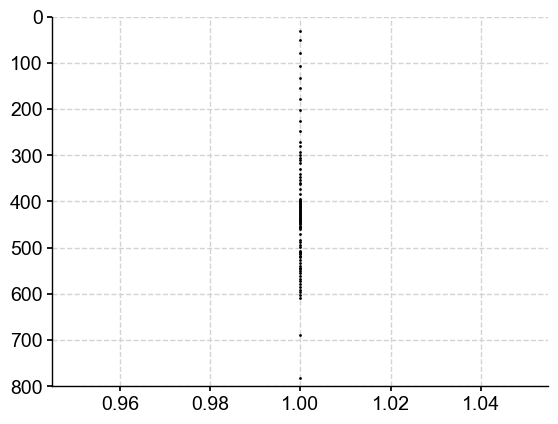

In [42]:
thelist = [1] * 86
fig, ax = plt.subplots()

ax.scatter(thelist, c20_area['depth'], c='k',s=1)
ax.set(ylim=(800, 0))
fig.savefig("depths.pdf")

plt.show()


In [21]:
#Make all the wax area data into a single dataframe for math and plotting with Seaborn

# Merge the DataFrames one by one
wax_df = c20_area.merge(c21_area, on=['depth', 'ageMedian'], suffixes=('_areac20', '_areac21'))
wax_df = wax_df.merge(c22_area, on=['depth', 'ageMedian'], suffixes=('_areac21', '_areac22'))
wax_df = wax_df.merge(c23_area, on=['depth', 'ageMedian'], suffixes=('_areac22', '_areac23'))
wax_df = wax_df.merge(c24_area, on=['depth', 'ageMedian'], suffixes=('_areac23', '_areac24'))
wax_df = wax_df.merge(c25_area, on=['depth', 'ageMedian'], suffixes=('_areac24', '_areac25'))
wax_df = wax_df.merge(c26_area, on=['depth', 'ageMedian'], suffixes=('_areac25', '_areac26'))
wax_df = wax_df.merge(c27_area, on=['depth', 'ageMedian'], suffixes=('_areac26', '_areac27'))
wax_df = wax_df.merge(c28_area, on=['depth', 'ageMedian'], suffixes=('_areac27', '_areac28'))
wax_df = wax_df.merge(c29_area, on=['depth', 'ageMedian'], suffixes=('_areac28', '_areac29'))
wax_df = wax_df.merge(c30_area, on=['depth', 'ageMedian'], suffixes=('_areac29', '_areac30'))
wax_df = wax_df.merge(c31_area, on=['depth', 'ageMedian'], suffixes=('_areac30', '_areac31'))
wax_df = wax_df.merge(c32_area, on=['depth', 'ageMedian'], suffixes=('_areac31', '_areac32'))
wax_df = wax_df.merge(c20_conc, on=['depth', 'ageMedian'], suffixes=('_areac32', '_conc20'))
wax_df = wax_df.merge(c22_conc, on=['depth', 'ageMedian'], suffixes=('_conc20', '_conc22'))
wax_df = wax_df.merge(c24_conc, on=['depth', 'ageMedian'], suffixes=('_conc22', '_conc24'))
wax_df = wax_df.merge(c26_conc, on=['depth', 'ageMedian'], suffixes=('_conc24', '_conc26'))
wax_df = wax_df.merge(c28_conc, on=['depth', 'ageMedian'], suffixes=('_conc26', '_conc28'))
wax_df = wax_df.merge(c30_conc, on=['depth', 'ageMedian'], suffixes=('_conc28', '_conc30'))

#rename the columns to be brief
wax_df = wax_df.rename(columns={'paleoData_values_areac20': 'C20','paleoData_values_areac21': 'C21',
                                        'paleoData_values_areac22': 'C22','paleoData_values_areac23': 'C23',
                                        'paleoData_values_areac24': 'C24','paleoData_values_areac25': 'C25',
                                        'paleoData_values_areac24': 'C24','paleoData_values_areac25': 'C25',
                                        'paleoData_values_areac26': 'C26','paleoData_values_areac27': 'C27',
                                        'paleoData_values_areac28': 'C28','paleoData_values_areac29': 'C29',
                                        'paleoData_values_areac30': 'C30','paleoData_values_areac31': 'C31',
                                        'paleoData_values_areac32': 'C32','paleoData_values_conc20': 'C20conc',
                                        'paleoData_values_conc22': 'C22conc','paleoData_values_conc24': 'C24conc',
                                        'paleoData_values_conc26': 'C26conc','paleoData_values_conc28': 'C28conc',
                                        'paleoData_values': 'C30conc',
                                        })


# Display the resulting merged DataFrame
print(wax_df)


    depth    ageMedian  C20  C21  C22  C23  C24  C25  C26  C27  C28  C29  C30  \
0      31   -11.412127   99   47  238   96  494  115  460   90  324   55  151   
1      51   305.387259  120   59  255  120  600  153  622  122  425   66  175   
2      79   993.553336   78   37  200   89  481  124  521  102  374   58  158   
3     107  1373.173196  105   49  232  105  563  154  652  134  480   77  206   
4     133  1831.760492   61   31  141   71  384  109  530  105  396   59  159   
..    ...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
81    597          NaN   13   12   34   23  101   42  134   37  104   17   31   
82    603          NaN    8   10   23   17   66   29   79   30   77   19   36   
83    609          NaN   16    6   22   16   71   35  114   35  109   23   51   
84    689          NaN   14    6   18   12   56   26   84   25   74   14   31   
85    783          NaN   14    5   22   15   93   30  139   27  120   15   47   

     C31   C32  C20conc  C2

In [22]:
# Select only the columns you want to normalize
selected_columns = ['depth','ageMedian','C20','C22','C24','C26','C28','C30']
norm_columns = ['C20','C22','C24','C26','C28','C30']

# Normalize the selected columns
Acids_normalized = wax_df[selected_columns].copy()
Acids_normalized[norm_columns] = wax_df[norm_columns].div(wax_df[norm_columns].sum(axis=1), axis=0)
Acids_normalized
#print(Imandra_Acids_normalized[norm_columns].sum(axis=1))

,depth,ageMedian,C20,C22,C24,C26,C28,C30
0,31,-11.412127,0.056059,0.134768,0.279728,0.260476,0.183465,0.085504
1,51,305.387259,0.054620,0.116067,0.273100,0.283113,0.193446,0.079654
2,79,993.553336,0.043046,0.110375,0.265453,0.287528,0.206402,0.087196
3,107,1373.173196,0.046917,0.103664,0.251564,0.291332,0.214477,0.092046
4,133,1831.760492,0.036505,0.084381,0.229803,0.317175,0.236984,0.095153
...,...,...,...,...,...,...,...,...
81,597,NaN,0.031175,0.081535,0.242206,0.321343,0.249400,0.074341
82,603,NaN,0.027682,0.079585,0.228374,0.273356,0.266436,0.124567
83,609,NaN,0.041775,0.057441,0.185379,0.297650,0.284595,0.133159
84,689,NaN,0.050542,0.064982,0.202166,0.303249,0.267148,0.111913


In [23]:
#calculate Average Chain Length
norm_columns = ['C20','C22','C24','C26','C28','C30']
wax_df['ACL']=(20*wax_df['C20']+22*wax_df['C22']+24*wax_df['C24']+26*wax_df['C26']+28*wax_df['C28']+30*wax_df['C30'])/(wax_df[norm_columns].sum(axis=1))
wax_df

,depth,ageMedian,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C20conc,C22conc,C24conc,C26conc,C28conc,C30conc,ACL
0,31,-11.412127,99,47,238,96,494,115,460,90,324,55,151,21.0,53.0,8.7,20.8,43.2,40.2,28.3,13.2,25.274066
1,51,305.387259,120,59,255,120,600,153,622,122,425,66,175,24.0,55.0,7.1,14.2,32.3,33.4,23.1,10.0,25.367319
2,79,993.553336,78,37,200,89,481,124,521,102,374,58,158,22.0,53.0,6.9,17.6,42.2,45.8,32.9,13.9,25.530905
3,107,1373.173196,105,49,232,105,563,154,652,134,480,77,206,28.0,66.0,5.7,11.7,27.4,31.6,23.5,10.5,25.597855
4,133,1831.760492,61,31,141,71,384,109,530,105,396,59,159,21.0,48.0,6.5,13.3,33.9,46.4,35.0,14.8,25.838420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,597,NaN,13,12,34,23,101,42,134,37,104,17,31,4.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,25.798561
82,603,NaN,8,10,23,17,66,29,79,30,77,19,36,7.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,26.089965
83,609,NaN,16,6,22,16,71,35,114,35,109,23,51,9.0,19.0,0.2,0.2,0.7,1.2,1.1,0.5,26.250653
84,689,NaN,14,6,18,12,56,26,84,25,74,14,31,5.0,11.0,0.5,0.5,1.1,1.6,1.4,0.7,26.014440


In [24]:
#calculate Carbon Preference Index
odds = ['C21','C23','C25','C27','C29']
small_evens = ['C20','C22','C24','C26','C28']
large_evens = ['C22','C24','C26','C28','C30']
wax_df['CPI']=0.5*(((wax_df[small_evens].sum(axis=1))/(wax_df[odds].sum(axis=1)))+((wax_df[large_evens].sum(axis=1))/(wax_df[odds].sum(axis=1))))
wax_df

,depth,ageMedian,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C20conc,C22conc,C24conc,C26conc,C28conc,C30conc,ACL,CPI
0,31,-11.412127,99,47,238,96,494,115,460,90,324,55,151,21.0,53.0,8.7,20.8,43.2,40.2,28.3,13.2,25.274066,4.071960
1,51,305.387259,120,59,255,120,600,153,622,122,425,66,175,24.0,55.0,7.1,14.2,32.3,33.4,23.1,10.0,25.367319,3.941346
2,79,993.553336,78,37,200,89,481,124,521,102,374,58,158,22.0,53.0,6.9,17.6,42.2,45.8,32.9,13.9,25.530905,4.131707
3,107,1373.173196,105,49,232,105,563,154,652,134,480,77,206,28.0,66.0,5.7,11.7,27.4,31.6,23.5,10.5,25.597855,4.012524
4,133,1831.760492,61,31,141,71,384,109,530,105,396,59,159,21.0,48.0,6.5,13.3,33.9,46.4,35.0,14.8,25.838420,4.162667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,597,NaN,13,12,34,23,101,42,134,37,104,17,31,4.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,25.798561,3.015267
82,603,NaN,8,10,23,17,66,29,79,30,77,19,36,7.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,26.089965,2.542857
83,609,NaN,16,6,22,16,71,35,114,35,109,23,51,9.0,19.0,0.2,0.2,0.7,1.2,1.1,0.5,26.250653,3.039130
84,689,NaN,14,6,18,12,56,26,84,25,74,14,31,5.0,11.0,0.5,0.5,1.1,1.6,1.4,0.7,26.014440,3.066265


In [25]:
#calculate Carbon Preference Index for long-chain waxes
odds_long = ['C27','C29']
small_evens_long = ['C26','C28']
large_evens_long = ['C28','C30']
wax_df['CPI_long']=0.5*(((wax_df[small_evens_long].sum(axis=1))/(wax_df[odds_long].sum(axis=1)))+((wax_df[large_evens_long].sum(axis=1))/(wax_df[odds_long].sum(axis=1))))
wax_df

,depth,ageMedian,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C20conc,C22conc,C24conc,C26conc,C28conc,C30conc,ACL,CPI,CPI_long
0,31,-11.412127,99,47,238,96,494,115,460,90,324,55,151,21.0,53.0,8.7,20.8,43.2,40.2,28.3,13.2,25.274066,4.071960,4.341379
1,51,305.387259,120,59,255,120,600,153,622,122,425,66,175,24.0,55.0,7.1,14.2,32.3,33.4,23.1,10.0,25.367319,3.941346,4.380319
2,79,993.553336,78,37,200,89,481,124,521,102,374,58,158,22.0,53.0,6.9,17.6,42.2,45.8,32.9,13.9,25.530905,4.131707,4.459375
3,107,1373.173196,105,49,232,105,563,154,652,134,480,77,206,28.0,66.0,5.7,11.7,27.4,31.6,23.5,10.5,25.597855,4.012524,4.308057
4,133,1831.760492,61,31,141,71,384,109,530,105,396,59,159,21.0,48.0,6.5,13.3,33.9,46.4,35.0,14.8,25.838420,4.162667,4.515244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,597,NaN,13,12,34,23,101,42,134,37,104,17,31,4.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,25.798561,3.015267,3.453704
82,603,NaN,8,10,23,17,66,29,79,30,77,19,36,7.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,26.089965,2.542857,2.744898
83,609,NaN,16,6,22,16,71,35,114,35,109,23,51,9.0,19.0,0.2,0.2,0.7,1.2,1.1,0.5,26.250653,3.039130,3.301724
84,689,NaN,14,6,18,12,56,26,84,25,74,14,31,5.0,11.0,0.5,0.5,1.1,1.6,1.4,0.7,26.014440,3.066265,3.371795


In [26]:
# Select only the columns you want to include in the melted DataFrame for plotting fractional abundance data
selected_columns = ['depth', 'C20','C22','C24','C26','C28','C30']

# Melt the DataFrame with selected columns
melted_df = pd.melt(Acids_normalized[selected_columns], id_vars=['depth'], var_name='Chain Length', value_name='FAME_FracAbund')

melted_df

,depth,Chain Length,FAME_FracAbund
0,31,C20,0.056059
1,51,C20,0.054620
2,79,C20,0.043046
3,107,C20,0.046917
4,133,C20,0.036505
...,...,...,...
511,597,C30,0.074341
512,603,C30,0.124567
513,609,C30,0.133159
514,689,C30,0.111913


/Users/elizabeth/anaconda3/envs/pyleo/lib/python3.10/site-packages/seaborn/_core/plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


<Figure size 640x480 with 0 Axes>

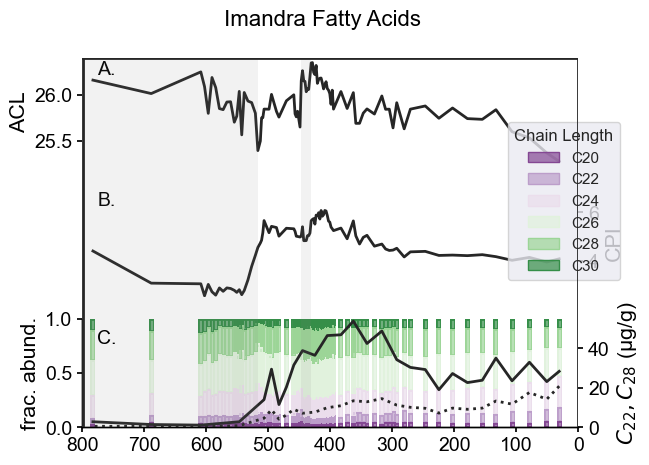

In [27]:
plt.figure(1)
fig, axs = plt.subplots(3, 1,sharex=False)

# Generate equally spaced colors from 'PRGn' colormap excluding the white color
colors = [cm.PRGn(i / (8 - 1)) for i in range(8)]

# Calculate the position for letter label in each subplot
x_pos = 0.03  # Adjust the x-coordinate as needed
y_pos = 0.97   # Adjust the y-coordinate as needed


ax = axs[0]
ax.plot(wax_df['depth'],wax_df['ACL'],c='k')
ax.set_xlim(800,0)
ax.set_xlabel(None)
ax.set_ylabel('ACL')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Remove grid lines and tick labels
ax.grid(False)
ax.set_xticks([])
ax.patch.set_alpha(0)
#add a panel label to the top left of the plot
ax.text(x_pos, y_pos, f"A.", transform=ax.transAxes,
        fontsize=14, va='top', ha='left')

ax = axs[1]
ax.plot(wax_df['depth'],wax_df['CPI'],c='k')
ax.set_xlim(800,0)
ax.set_xlabel(None)
ax.set_ylim(2.5,7)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('CPI')
# Remove grid lines and tick labels
ax.grid(False)
ax.set_xticks([])
ax.patch.set_alpha(0)
# Move y-axis ticks and labels to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
#add a panel label to the top left of the plot
ax.text(x_pos, y_pos, f"B.", transform=ax.transAxes,
        fontsize=14, va='top', ha='left')

#ax.get_legend().remove()

#ax_twin2 = axs[2].twinx()
#ax_twin2.plot(wax_df['depth'],wax_df['C28conc'],c='k')
#ax_twin2.plot(wax_df['depth'],wax_df['C22conc'],c='k',linestyle=':')
#ax_twin2.set_ylim(0,55)
#ax_twin2.set_ylabel('$C_{22},  C_{28}$ (µg/g)')

# Filter out NaNs before plotting
depth_valid_28 = wax_df['depth'][wax_df['C28conc'].notna()]
C28conc_valid = wax_df['C28conc'].dropna()

depth_valid_22 = wax_df['depth'][wax_df['C22conc'].notna()]
C22conc_valid = wax_df['C22conc'].dropna()

# Create a twin y-axis for axs[2]
# Plot the filtered data
ax_twin2 = axs[2].twinx()
ax_twin2.plot(depth_valid_28, C28conc_valid, c='k')
ax_twin2.plot(depth_valid_22, C22conc_valid, c='k', linestyle=':')
ax_twin2.set_ylim(0, 55)
ax_twin2.set_ylabel('$C_{22},  C_{28}$ (µg/g)')
ax_twin2.grid(False)
ax.spines['right'].set_visible(False)
ax.patch.set_alpha(0)
# Remove grid lines
ax.grid(False)

# Select only the columns you want to include in the melted DataFrame for plotting fractional abundance data
#selected_columns = ['depth', 'C20','C22','C24','C26','C28','C30']

# Melt the DataFrame with selected columns
#melted_df = pd.melt(Imandra_Acids_normalized[selected_columns], id_vars=['depth'], var_name='FracAbund', value_name='FAME_conc')

#define the seaborn object bar plot
fa=(
    so.Plot(melted_df, x="depth", y="FAME_FracAbund", color="Chain Length")
    .add(so.Bar(width=4), so.Stack()).scale(color="PRGn",alpha=1)
    .share(y=False)
    .label(x=None, y="frac. abund.") 
#    .legend(False)
)
#fa.legend().remove() 
ax = axs[2]
ax.set_xlim(800,0)
ax.set_ylim(0,1)
# Remove grid lines
ax.grid(False)
ax.patch.set_alpha(0)
# Add a title to the entire figure
fig.suptitle('Imandra Fatty Acids', fontsize=16)

#ET can't get these ax_full commands to work.
ax_full = fig.add_subplot(111,zorder=10)
ax_full.set_axis_off()
ax_full.set_xlim(800,0)

#draw a rectangle to highlight specific time span in the plot
ax_full.axvspan(800,516,facecolor='gray',ec=None,zorder=-1,alpha=0.1)
ax_full.axvspan(447,431,facecolor='gray',ec=None,zorder=-1,alpha=0.1)

#draw black lines around the plot
ax_full.axvline(799,0,1,color='k',zorder=1,lw=2)
ax_full.axvline(1,0,1,color='k',zorder=1,lw=2)
ax_full.axhline(.999,799,0,color='k',zorder=1,lw=2)
#add a panel label to the top left of the plot
ax_full.text(x_pos, .9, f"C.", transform=ax.transAxes,
        fontsize=14, va='top', ha='left')

fa.on(ax).show()
#trying to adjust position of legend, found this: https://stackoverflow.com/questions/73633322/how-can-i-customize-the-legend-with-seaborn-0-12-objects
#but it doesn't work (no errors, just isn't reading the right legend)
#fig.legends[0].set_bbox_to_anchor((0, 0))
#this also doesn't work (no errors, just isn't reading the right legend)
#ax.legend(bbox_to_anchor=(0, 0))

fig.set_size_inches(12, 10)

fig.savefig("AcidResults.pdf")#, dpi=300, bbox_inches="tight")  # Adjust the file name and dpi as needed

plt.show()



In [153]:
#now select the GDGT data for plotting
# Must create two variables, one for the returned 'ensemble' and one for the returned 'age_axis'
IIIa5_ens, IIIa5 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-IIIa5me',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

IIIa6_ens, IIIa6 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-IIIa6me',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

IIIb5_ens, IIIb5 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-IIIb5me',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

IIIb6_ens, IIIb6 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-IIIb6me',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

IIIc5_ens, IIIc5 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-IIIc5me',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

IIIc6_ens, IIIc6 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-IIIc6me',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

IIa5_ens, IIa5 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-IIa5me',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

IIa6_ens, IIa6 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-IIa6me',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

IIb5_ens, IIb5 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-IIb5me',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

IIb6_ens, IIb6 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-IIb6me',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

IIc5_ens, IIc5 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-IIc5me',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

IIc6_ens, IIc6 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-IIc6me',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

Ia_ens, Ia = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-Ia',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

Ib_ens, Ib = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-Ib',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

Ic_ens, Ic = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='brGDGT-Ic',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

brGDGTconc_ens, brGDGTconc = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='totalbrgdgtconc',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

MBT5me_ens, MBT5me = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='MBT',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

GDGT0_ens, GDGT0 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='GDGT-0',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

GDGT1_ens, GDGT1 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='GDGT-1',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )

GDGT2_ens, GDGT2 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='GDGT-2',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )
GDGT3_ens, GDGT3 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='GDGT-3',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )
GDGT4_ens, GDGT4 = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='Cren',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )
GDGT4p_ens, GDGT4p = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName="Cren'",
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )
isoGDGTconc_ens, isoGDGTconc = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='totalisogdgtconc',
                                           depth_name='midpointdepth',
                                           val_unit='percent'
                                           )


Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  4.91it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  5.00it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  5.02it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  5.08it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  4.56it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  5.05it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  4.31it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  5.26it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  5.14it/s]

Loaded..


             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  5.19it/s]

Loaded..


             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  5.04it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  4.67it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  4.94it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  4.94it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...
Loading 1 LiPD files


100%|███████████████████████████████████████████████| 1/1 [00:00<00:00,  5.19it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...


In [154]:
# Remove rows with duplicates in the 'depth' column, keeping the first occurrence
IIIa5 = IIIa5.drop_duplicates(subset=['depth'], keep='first')
IIIa6 = IIIa6.drop_duplicates(subset=['depth'], keep='first')
IIIb5 = IIIb5.drop_duplicates(subset=['depth'], keep='first')
IIIb6 = IIIb6.drop_duplicates(subset=['depth'], keep='first')
IIIc5 = IIIc5.drop_duplicates(subset=['depth'], keep='first')
IIIc6 = IIIc6.drop_duplicates(subset=['depth'], keep='first')
IIa5 = IIa5.drop_duplicates(subset=['depth'], keep='first')
IIa6 = IIa6.drop_duplicates(subset=['depth'], keep='first')
IIb5 = IIb5.drop_duplicates(subset=['depth'], keep='first')
IIb6 = IIb6.drop_duplicates(subset=['depth'], keep='first')
IIc5 = IIc5.drop_duplicates(subset=['depth'], keep='first')
IIc6 = IIc6.drop_duplicates(subset=['depth'], keep='first')
Ia = Ia.drop_duplicates(subset=['depth'], keep='first')
Ib = Ib.drop_duplicates(subset=['depth'], keep='first')
Ic = Ic.drop_duplicates(subset=['depth'], keep='first')
brGDGTconc = brGDGTconc.drop_duplicates(subset=['depth'], keep='first')
MBT5me = MBT5me.drop_duplicates(subset=['depth'], keep='first')
GDGT0 = GDGT0.drop_duplicates(subset=['depth'], keep='first')
GDGT1 = GDGT1.drop_duplicates(subset=['depth'], keep='first')
GDGT2 = GDGT2.drop_duplicates(subset=['depth'], keep='first')
GDGT3 = GDGT3.drop_duplicates(subset=['depth'], keep='first')
GDGT4 = GDGT4.drop_duplicates(subset=['depth'], keep='first')
GDGT4p = GDGT4p.drop_duplicates(subset=['depth'], keep='first')
isoGDGTconc = isoGDGTconc.drop_duplicates(subset=['depth'], keep='first')


In [155]:
#Make all the data into a single dataframe for plotting with Seaborn

# Merge the DataFrames one by one
brGDGT_df = Ia.merge(Ib, on=['depth', 'ageMedian'], suffixes=('_Ia', '_Ib'))
brGDGT_df = brGDGT_df.merge(Ic, on=['depth', 'ageMedian'], suffixes=('_Ib', '_Ic'))
brGDGT_df = brGDGT_df.merge(IIa5, on=['depth', 'ageMedian'], suffixes=('_Ic', '_IIa5'))
brGDGT_df = brGDGT_df.merge(IIa6, on=['depth', 'ageMedian'], suffixes=('_IIa5', '_IIa6'))
brGDGT_df = brGDGT_df.merge(IIb5, on=['depth', 'ageMedian'], suffixes=('_IIa6', '_IIb5'))
brGDGT_df = brGDGT_df.merge(IIb6, on=['depth', 'ageMedian'], suffixes=('_IIb5', '_IIb6'))
brGDGT_df = brGDGT_df.merge(IIc5, on=['depth', 'ageMedian'], suffixes=('_IIb6', '_IIc5'))
brGDGT_df = brGDGT_df.merge(IIc6, on=['depth', 'ageMedian'], suffixes=('_IIc5', '_IIc6'))
brGDGT_df = brGDGT_df.merge(IIIa5, on=['depth', 'ageMedian'], suffixes=('_IIc6', '_IIIa5'))
brGDGT_df = brGDGT_df.merge(IIIa6, on=['depth', 'ageMedian'], suffixes=('_IIIa5', '_IIIa6'))
brGDGT_df = brGDGT_df.merge(IIIb5, on=['depth', 'ageMedian'], suffixes=('_IIIa6', '_IIIb5'))
brGDGT_df = brGDGT_df.merge(IIIb6, on=['depth', 'ageMedian'], suffixes=('_IIIb5', '_IIIb6'))
brGDGT_df = brGDGT_df.merge(IIIc5, on=['depth', 'ageMedian'], suffixes=('_IIIb6', '_IIIc5'))
brGDGT_df = brGDGT_df.merge(IIIc6, on=['depth', 'ageMedian'], suffixes=('_IIIc5', '_IIIc6'))

brGDGT_df = brGDGT_df.rename(columns={'paleoData_values_Ia': 'Ia','paleoData_values_Ib': 'Ib','paleoData_values_Ic': 'Ic',
                                       'paleoData_values_IIa5': 'IIa5','paleoData_values_IIa6': 'IIa6','paleoData_values_IIb5': 'IIb5',
                                       'paleoData_values_IIb6': 'IIb6','paleoData_values_IIc5': 'IIc5','paleoData_values_IIc6': 'IIc6',
                                       'paleoData_values_IIIa5': 'IIIa5','paleoData_values_IIIa6': 'IIIa6','paleoData_values_IIIb5': 'IIIb5',
                                       'paleoData_values_IIIb6': 'IIIb6','paleoData_values_IIIc5': 'IIIc5','paleoData_values': 'IIIc6',
                                      })


#rename the columns to be brief
# wax_df = wax_df.rename(columns={'paleoData_values_areac20': 'C20','paleoData_values_areac21': 'C21',
#                                         'paleoData_values_areac22': 'C22','paleoData_values_areac23': 'C23',
#                                         'paleoData_values_areac24': 'C24','paleoData_values_areac25': 'C25',
#                                         'paleoData_values_areac24': 'C24','paleoData_values_areac25': 'C25',
#                                         'paleoData_values_areac26': 'C26','paleoData_values_areac27': 'C27',
#                                         'paleoData_values_areac28': 'C28','paleoData_values_areac29': 'C29',
#                                         'paleoData_values_areac30': 'C30','paleoData_values_areac31': 'C31',
#                                         'paleoData_values_areac32': 'C32','paleoData_values_conc20': 'C20conc',
#                                         'paleoData_values_conc22': 'C22conc','paleoData_values_conc24': 'C24conc',
#                                         'paleoData_values_conc26': 'C26conc','paleoData_values_conc28': 'C28conc',
#                                         'paleoData_values': 'C30conc',
#                                         })



# Display the resulting merged DataFrame
brGDGT_df


,depth,ageMedian,Ia,Ib,Ic,IIa5,IIa6,IIb5,IIb6,IIc5,IIc6,IIIa5,IIIa6,IIIb5,IIIb6,IIIc5,IIIc6
0,31,-11.412127,288.154483,28.865409,19.259662,335.814792,155.002716,34.664931,20.923988,15.411931,0.0,322.874755,119.267860,4.973508,8.211976,2.151634,0.0
1,51,305.387259,229.528552,28.023781,16.789533,262.107330,145.434968,33.503122,19.151383,12.752581,0.0,315.296696,117.190950,4.923324,8.354353,1.988641,0.0
2,79,993.553336,180.716426,21.998042,13.642702,200.730753,105.896889,26.490647,14.164487,10.917638,0.0,205.555673,79.224825,3.732182,4.994045,1.372069,0.0
3,107,1373.173196,198.041918,30.998704,18.531656,221.937937,120.862751,36.122102,19.029971,15.014530,0.0,255.697618,90.617786,4.954241,7.763893,2.247240,0.0
4,133,1831.760492,152.896231,32.227179,19.149820,184.083348,109.817844,38.072782,18.912691,15.415600,0.0,249.053495,82.021980,5.062319,8.317815,2.583408,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,597,NaN,7.238010,0.819293,0.000000,7.827173,1.468559,0.523525,0.000000,0.000000,0.0,5.168030,1.156579,0.427440,0.000000,0.000000,0.0
82,603,NaN,4.224430,0.000000,0.000000,4.333673,1.464521,0.565069,0.000000,0.000000,0.0,8.425016,2.958987,1.490584,0.000000,0.971541,0.0
83,609,NaN,4.004754,0.535803,0.000000,4.240219,1.523315,0.549480,0.000000,0.000000,0.0,6.188073,1.922718,0.880314,0.000000,0.545044,0.0
84,689,NaN,3.373506,0.410417,0.000000,3.464783,1.038971,0.234050,0.000000,0.000000,0.0,5.790699,0.891336,0.224105,0.000000,0.000000,0.0


In [156]:
#the GDGT data are stored as concentration or peak area, so need to convert to fractional abundance
# Select only the columns you want to normalize
br_selected_columns = ['Ia', 'Ib', 'Ic','IIa5', 'IIa6', 'IIb5', 'IIb6', 'IIc5', 'IIc6', 'IIIa5', 'IIIa6', 'IIIb5', 'IIIb6', 'IIIc5', 'IIIc6']

# Normalize the selected columns
brGDGT_df_norm = brGDGT_df.copy()
brGDGT_df_norm[br_selected_columns] = brGDGT_df[br_selected_columns].div(brGDGT_df[br_selected_columns].sum(axis=1), axis=0)
print(brGDGT_df_norm[br_selected_columns].sum(axis=1))

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
81    1.0
82    1.0
83    1.0
84    1.0
85    1.0
Length: 86, dtype: float64


In [157]:
#calculate Raberg fractional abundance by group
# Select only the columns you want to normalize
CI_I_br_selected_columns = ['Ia', 'Ib', 'Ic']
CI_II_br_selected_columns = ['IIa5', 'IIa6', 'IIb5', 'IIb6', 'IIc5', 'IIc6']
CI_III_br_selected_columns = ['IIIa5', 'IIIa6', 'IIIb5', 'IIIb6', 'IIIc5', 'IIIc6']

# Normalize the selected columns
Raberg_CI = brGDGT_df.copy()
Raberg_CI[CI_I_br_selected_columns] = brGDGT_df[CI_I_br_selected_columns].div(brGDGT_df[CI_I_br_selected_columns].sum(axis=1), axis=0)
Raberg_CI[CI_II_br_selected_columns] = brGDGT_df[CI_II_br_selected_columns].div(brGDGT_df[CI_II_br_selected_columns].sum(axis=1), axis=0)
Raberg_CI[CI_III_br_selected_columns] = brGDGT_df[CI_III_br_selected_columns].div(brGDGT_df[CI_III_br_selected_columns].sum(axis=1), axis=0)
Raberg_CI

,depth,ageMedian,Ia,Ib,Ic,IIa5,IIa6,IIb5,IIb6,IIc5,IIc6,IIIa5,IIIa6,IIIb5,IIIb6,IIIc5,IIIc6
0,31,-11.412127,0.856890,0.085838,0.057273,0.597728,0.275895,0.061701,0.037243,0.027432,0.0,0.705768,0.260706,0.010872,0.017950,0.004703,0.0
1,51,305.387259,0.836652,0.102149,0.061199,0.554197,0.307506,0.070839,0.040494,0.026964,0.0,0.704174,0.261731,0.010996,0.018658,0.004441,0.0
2,79,993.553336,0.835269,0.101675,0.063056,0.560387,0.295636,0.073955,0.039543,0.030479,0.0,0.697085,0.268669,0.012657,0.016936,0.004653,0.0
3,107,1373.173196,0.799936,0.125211,0.074854,0.537423,0.292669,0.087470,0.046081,0.036358,0.0,0.707753,0.250824,0.013713,0.021490,0.006220,0.0
4,133,1831.760492,0.748489,0.157765,0.093746,0.502545,0.299801,0.103938,0.051631,0.042084,0.0,0.717653,0.236348,0.014587,0.023968,0.007444,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,597,NaN,0.898317,0.101683,0.000000,0.797125,0.149559,0.053316,0.000000,0.000000,0.0,0.765402,0.171293,0.063305,0.000000,0.000000,0.0
82,603,NaN,1.000000,0.000000,0.000000,0.681046,0.230153,0.088802,0.000000,0.000000,0.0,0.608475,0.213705,0.107653,0.000000,0.070167,0.0
83,609,NaN,0.881996,0.118004,0.000000,0.671663,0.241298,0.087039,0.000000,0.000000,0.0,0.648907,0.201624,0.092313,0.000000,0.057156,0.0
84,689,NaN,0.891537,0.108463,0.000000,0.731306,0.219294,0.049401,0.000000,0.000000,0.0,0.838486,0.129064,0.032450,0.000000,0.000000,0.0


In [158]:
#calculate Raberg fractional abundance by group
# Select only the columns you want to normalize
Meth_a_br_selected_columns = ['Ia','IIa5','IIIa5']
Meth_ap_br_selected_columns = ['IIa6','IIIa6']
Meth_b_br_selected_columns = ['Ib','IIb5', 'IIIb5']
Meth_bp_br_selected_columns = ['IIb6', 'IIIb6']
Meth_c_br_selected_columns = ['Ic', 'IIc5','IIIc5']
Meth_cp_br_selected_columns = ['IIc6','IIIc6']

# Normalize the selected columns
Raberg_Meth = brGDGT_df.copy()
Raberg_Meth[Meth_a_br_selected_columns] = brGDGT_df[Meth_a_br_selected_columns].div(brGDGT_df[Meth_a_br_selected_columns].sum(axis=1), axis=0)
Raberg_Meth[Meth_ap_br_selected_columns] = brGDGT_df[Meth_ap_br_selected_columns].div(brGDGT_df[Meth_ap_br_selected_columns].sum(axis=1), axis=0)
Raberg_Meth[Meth_b_br_selected_columns] = brGDGT_df[Meth_b_br_selected_columns].div(brGDGT_df[Meth_b_br_selected_columns].sum(axis=1), axis=0)
Raberg_Meth[Meth_bp_br_selected_columns] = brGDGT_df[Meth_bp_br_selected_columns].div(brGDGT_df[Meth_bp_br_selected_columns].sum(axis=1), axis=0)
Raberg_Meth[Meth_c_br_selected_columns] = brGDGT_df[Meth_c_br_selected_columns].div(brGDGT_df[Meth_c_br_selected_columns].sum(axis=1), axis=0)
Raberg_Meth[Meth_cp_br_selected_columns] = brGDGT_df[Meth_cp_br_selected_columns].div(brGDGT_df[Meth_cp_br_selected_columns].sum(axis=1), axis=0)
Raberg_Meth

,depth,ageMedian,Ia,Ib,Ic,IIa5,IIa6,IIb5,IIb6,IIc5,IIc6,IIIa5,IIIa6,IIIb5,IIIb6,IIIc5,IIIc6
0,31,-11.412127,0.304332,0.421369,0.523030,0.354667,0.565145,0.506029,0.718150,0.418538,NaN,0.341001,0.434855,0.072602,0.281850,0.058431,NaN
1,51,305.387259,0.284446,0.421726,0.532481,0.324819,0.553772,0.504184,0.696269,0.404449,NaN,0.390735,0.446228,0.074090,0.303731,0.063070,NaN
2,79,993.553336,0.307863,0.421250,0.526087,0.341959,0.572039,0.507281,0.739331,0.421004,NaN,0.350178,0.427961,0.071469,0.260669,0.052909,NaN
3,107,1373.173196,0.293101,0.430089,0.517739,0.328467,0.571508,0.501173,0.710236,0.419477,NaN,0.378431,0.428492,0.068737,0.289764,0.062784,NaN
4,133,1831.760492,0.260900,0.427630,0.515489,0.314118,0.572445,0.505197,0.694541,0.414969,NaN,0.424982,0.427555,0.067173,0.305459,0.069542,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,597,NaN,0.357729,0.462810,NaN,0.386848,0.559422,0.295734,NaN,NaN,NaN,0.255423,0.440578,0.241456,NaN,NaN,NaN
82,603,NaN,0.248743,0.000000,0.000000,0.255175,0.331077,0.274885,NaN,0.000000,NaN,0.496082,0.668923,0.725115,NaN,1.000000,NaN
83,609,NaN,0.277471,0.272591,0.000000,0.293785,0.442049,0.279549,NaN,0.000000,NaN,0.428743,0.557951,0.447861,NaN,1.000000,NaN
84,689,NaN,0.267124,0.472519,NaN,0.274352,0.538241,0.269466,NaN,NaN,NaN,0.458524,0.461759,0.258015,NaN,NaN,NaN


In [166]:
brGDGTconc

,depth,ageMedian,paleoData_values
0,31,-11.412127,2502.219929
1,51,305.387259,2557.614154
2,79,993.553336,1812.345234
3,107,1373.173196,1943.252279
4,133,1831.760492,2032.098750
...,...,...,...
84,597,NaN,26.514022
85,603,NaN,23.038821
86,609,NaN,20.011894
87,689,NaN,17.832590


In [159]:
#Make all the data into a single dataframe for plotting with Seaborn

# Merge the DataFrames one by one
isoGDGT_df = GDGT0.merge(GDGT1, on=['depth', 'ageMedian'], suffixes=('_iso0', '_iso1'))
isoGDGT_df = isoGDGT_df.merge(GDGT2, on=['depth', 'ageMedian'], suffixes=('_iso1', '_iso2'))
isoGDGT_df = isoGDGT_df.merge(GDGT3, on=['depth', 'ageMedian'], suffixes=('_iso2', '_iso3'))
isoGDGT_df = isoGDGT_df.merge(GDGT4, on=['depth', 'ageMedian'], suffixes=('_iso3', '_cren'))
isoGDGT_df = isoGDGT_df.merge(GDGT4p, on=['depth', 'ageMedian'], suffixes=('_cren', '_crenreg'))

isoGDGT_df = isoGDGT_df.rename(columns={'paleoData_values_iso0': 'iso0','paleoData_values_iso1': 'iso1',
                                        'paleoData_values_iso2': 'iso2','paleoData_values_iso3': 'iso3',
                                        'paleoData_values_cren': 'cren','paleoData_values_crenreg': 'crenreg',
                                        })

# Display the resulting merged DataFrame
isoGDGT_df


,depth,ageMedian,iso0,iso1,iso2,iso3,cren,crenreg
0,31,-11.412127,47.218094,17.505662,7.890179,2.132162,69.218668,1.807291
1,51,305.387259,45.747964,18.631168,7.430010,1.947957,74.321253,1.743994
2,79,993.553336,36.132858,13.497739,5.998618,1.600536,53.163983,1.373765
3,107,1373.173196,40.608870,16.304175,7.217866,1.917600,64.267780,1.746514
4,133,1831.760492,38.800245,16.806220,7.775232,1.953298,65.120194,1.813521
...,...,...,...,...,...,...,...,...
81,597,NaN,0.977853,0.000000,0.000000,0.000000,0.000000,0.000000
82,603,NaN,0.909434,0.000000,0.000000,0.000000,0.000000,0.000000
83,609,NaN,0.761103,0.000000,0.000000,0.000000,0.246739,0.000000
84,689,NaN,0.554516,0.000000,0.000000,0.000000,0.325770,0.000000


In [160]:
#the GDGT data are stored as concentration or peak area, so need to convert to fractional abundance
# Select only the columns you want to normalize
iso_selected_columns = ['iso0', 'iso1', 'iso2','iso3', 'cren', 'crenreg']

# Normalize the selected columns
isoGDGT_df_norm = isoGDGT_df.copy()
isoGDGT_df_norm[iso_selected_columns] = isoGDGT_df[iso_selected_columns].div(isoGDGT_df[iso_selected_columns].sum(axis=1), axis=0)
print(isoGDGT_df_norm[iso_selected_columns].sum(axis=1))

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
81    1.0
82    1.0
83    1.0
84    1.0
85    1.0
Length: 86, dtype: float64


In [161]:
isoGDGT_df_norm

,depth,ageMedian,iso0,iso1,iso2,iso3,cren,crenreg
0,31,-11.412127,0.323917,0.120089,0.054127,0.014627,0.474842,0.012398
1,51,305.387259,0.305348,0.124355,0.049592,0.013002,0.496063,0.011640
2,79,993.553336,0.323286,0.120766,0.053671,0.014320,0.475666,0.012291
3,107,1373.173196,0.307497,0.123458,0.054655,0.014520,0.486646,0.013225
4,133,1831.760492,0.293344,0.127061,0.058784,0.014768,0.492333,0.013711
...,...,...,...,...,...,...,...,...
81,597,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
82,603,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
83,609,NaN,0.755181,0.000000,0.000000,0.000000,0.244819,0.000000
84,689,NaN,0.629927,0.000000,0.000000,0.000000,0.370073,0.000000


<Figure size 640x480 with 0 Axes>

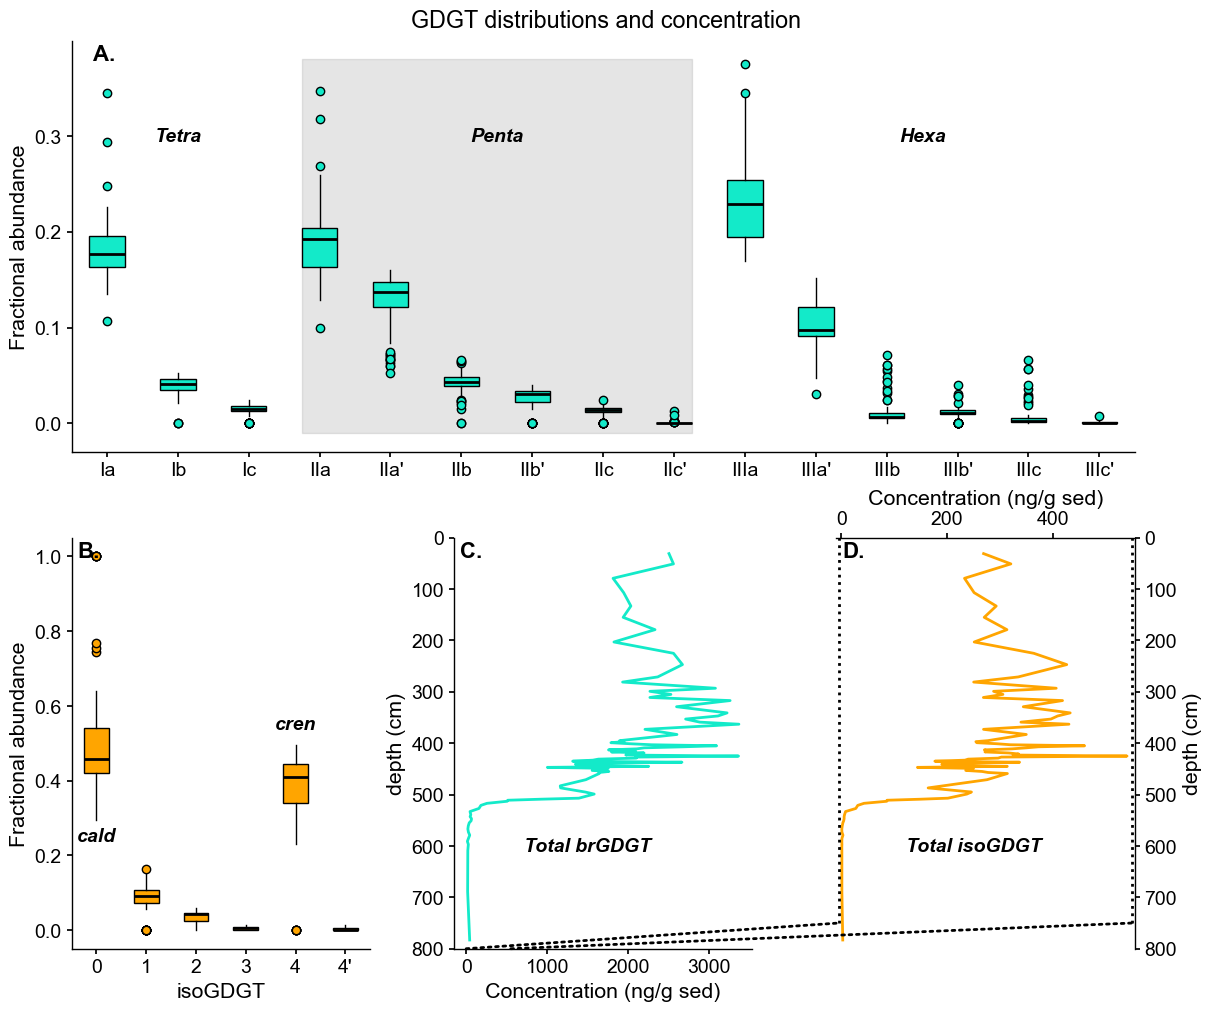

In [174]:
plt.figure(2)

fig = plt.figure(layout="constrained")

# Calculate the position for letter label in each subplot
x_pos = 0.02  # Adjust the x-coordinate as needed
y_pos = 0.99   # Adjust the y-coordinate as needed


gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])

fig.suptitle("GDGT distributions and concentration")
#format_axes(fig)

ax = ax1
boxplot=ax.boxplot(brGDGT_df_norm[br_selected_columns], showcaps=False,patch_artist=True,
            boxprops=dict(facecolor='#13EAC9'),
            flierprops=dict(markerfacecolor='#13EAC9'),
            medianprops=dict(color='k', linewidth=2)
           )

ax.set_xticklabels(labels= ("Ia","Ib","Ic","IIa","IIa'","IIb","IIb'","IIc","IIc'","IIIa","IIIa'","IIIb","IIIb'","IIIc","IIIc'"))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.1))  # y-axis ticks at multiples of 0.1
ax.set_ylabel('Fractional abundance')
# Remove grid lines
ax.grid(False)

# Define the boxes you want to shade (e.g., boxes 4-9 out of 15)
box_start, box_end = 3, 8

# Extract box positions
box_paths = [patch.get_path() for patch in boxplot['boxes']]

# Find the corresponding x-values for the start and end of the shaded area
x_start = box_paths[box_start].vertices[:, 0].min()
x_end = box_paths[box_end].vertices[:, 0].max()

# Fill the area between x_start and x_end with a shaded color
ax.fill_betweenx(y=[-.01, 0.38], x1=x_start, x2=x_end, color='gray', alpha=0.2)

# Add text at a specific position
ax.text(2, 0.3, 'Tetra', fontsize=14, ha='center', va='center', color='black', weight='bold', style='italic')
ax.text(6.5, 0.3, 'Penta', fontsize=14, ha='center', va='center', color='black', weight='bold', style='italic')
ax.text(12.5, 0.3, 'Hexa', fontsize=14, ha='center', va='center', color='black', weight='bold', style='italic')
# Add letter label to the upper left corner of the subplot
ax.text(x_pos, y_pos, f"A.", transform=ax.transAxes,
        fontsize=16, fontweight='bold', va='top', ha='left')

ax = ax2
ax.boxplot(isoGDGT_df_norm[iso_selected_columns], showcaps=False,patch_artist=True,
            boxprops=dict(facecolor='orange'),
            flierprops=dict(markerfacecolor='orange'),
            medianprops=dict(color='k', linewidth=2)
          )
ax.set_xticklabels(labels= ("0","1","2","3","4","4'"))
ax.set_xlabel('isoGDGT')
ax.set_ylabel('Fractional abundance')
# Remove grid lines
ax.grid(False)
ax.text(1, .25, 'cald', fontsize=14, ha='center', va='center', color='black', weight='bold', style='italic')
ax.text(5, .55, 'cren', fontsize=14, ha='center', va='center', color='black', weight='bold', style='italic')
# Add letter label to the upper left corner of the subplot
ax.text(x_pos, y_pos, f"B.", transform=ax.transAxes,
        fontsize=16, fontweight='bold', va='top', ha='left')

ax = ax3
ax.plot(brGDGTconc['paleoData_values'],brGDGTconc['depth'],c='#13EAC9')
ax.set_ylim(800,0)
ax.set_xlabel('Concentration (ng/g sed)')
ax.set_ylabel('depth (cm)')
# Remove grid lines
ax.grid(False)
ax.text(1500, 600, 'Total brGDGT', fontsize=14, ha='center', va='center', color='black', weight='bold', style='italic')
# Add letter label to the upper left corner of the subplot
ax.text(x_pos, y_pos, f"C.", transform=ax.transAxes,
        fontsize=16, fontweight='bold', va='top', ha='left')

ax = ax4
ax.plot(isoGDGTconc['paleoData_values'],isoGDGTconc['depth'],c='orange')
ax.set_ylim(800,0)
ax.set_xlim(-10,555)
# Move x-axis ticks and labels to the top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
# Add letter label to the upper left corner of the subplot
ax.text(x_pos, y_pos, f"D.", transform=ax.transAxes,
        fontsize=16, fontweight='bold', va='top', ha='left')

# Move y-axis ticks and labels to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_ylabel('depth (cm)')

#ax.yaxis.set_ticklabels([])
ax.set_xlabel('Concentration (ng/g sed)')
# Move spines to the top and right
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
# Remove grid lines
ax.grid(False)
ax.text(250, 600, 'Total isoGDGT', fontsize=14, ha='center', va='center', color='black', weight='bold', style='italic')

# Add a line connecting 0 on the x-axes of ax3 and ax4
ax.plot([-5, -5], [750, 0], 'k:', linewidth=2)
ax.plot([550, 550], [750, 0], 'k:', linewidth=2)

con = ConnectionPatch(xyA=(0,800), xyB=(-5,750), coordsA="data", coordsB="data",
                      axesA=ax3, axesB=ax4,linestyle=':', linewidth=2, color='k')
fig.add_artist(con)

con2 = ConnectionPatch(xyA=(550,800), xyB=(550,750), coordsA="data", coordsB="data",
                      axesA=ax3, axesB=ax4,linestyle=':', linewidth=2, color='k')
fig.add_artist(con2)

fig.set_size_inches(12, 10)
fig.savefig("GDGTConcentrationResults.pdf")
plt.show()


In [175]:
#install package for ternary diagrams
!pip install -U mpltern

In [176]:
#import necessary packages for ternary diagrams
import mpltern
from mpltern.datasets import get_triangular_grid
from matplotlib.colors import LinearSegmentedColormap

In [178]:
#import global modern GDGT data & format for plotting on the ternary diagram
globalGDGT = pd.read_csv('/Users/elizabeth/Documents/python/GlobalGDGTs_20240118.csv')
globalGDGT

,Sample name,Sample group,Sample type,Sample subtype,Region,Site,Latitude (N),Longitude (E),Elevation (m asl),Temperature,Temperature parameter,MAF (C),WMT (C),MAT (C),pH,DO (mg/L),BIT,MBT'5Me,CBT',IR6Me,fIa,fIb,fIc,fIIa,fIIa',fIIb,fIIb',fIIc,fIIc',fIIIa,fIIIa',fIIIb,fIIIb',fIIIc,fIIIc',Reference,Max.Depth..m.,Area..km.2.,elevation_worldclim,MAP_worldclim,Cren,Crenp,GDGT-3,GDGT3p,GDGT-2,GDGT-2p,GDGT-1,GDGT-1p,GDGT-0
0,Dillon_2018 AK-09-02,Bone,Bone,Bone,WestæAlaska,AK-09-02,67.451000,-163.549000,NaN,NaN,NaN,8.100000,11.100000,-5.675000,NaN,NaN,NaN,0.436123,0.302394,0.452991,0.264264,0.033033,0.000000,0.263263,0.242242,0.010010,0.000000,0.000000,0.000000,0.111111,0.076076,0.00000,0.00000,0.0,0.0,Dillon et al. (2018),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Dillon_2018 TRC-01-01,Bone,Bone,Bone,"EastæCoast,æU.S.",TRC-01-01,35.182000,-83.382000,NaN,23.0,Warmest Month Air Temperature (WMT),13.066667,23.000000,13.066667,NaN,NaN,NaN,0.862500,0.068433,0.802691,0.396794,0.139279,0.017034,0.032064,0.249499,0.039078,0.052104,0.006012,0.003006,0.011022,0.054108,0.00000,0.00000,0.0,0.0,Dillon et al. (2018),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Dillon_2018 TRC-01-02,Bone,Bone,Bone,"EastæCoast,æU.S.",TRC-01-02,35.182000,-83.382000,NaN,23.0,Warmest Month Air Temperature (WMT),13.066667,23.000000,13.066667,NaN,NaN,NaN,0.902866,0.082382,0.859447,0.431568,0.124875,0.009990,0.024975,0.266733,0.025974,0.050949,0.003996,0.002997,0.005994,0.051948,0.00000,0.00000,0.0,0.0,Dillon et al. (2018),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Dillon_2018 TRC-01-03,Bone,Bone,Bone,"EastæCoast,æU.S.",TRC-01-03,35.182000,-83.382000,NaN,23.0,Warmest Month Air Temperature (WMT),13.066667,23.000000,13.066667,NaN,NaN,NaN,0.789617,0.106268,0.635071,0.316000,0.227000,0.035000,0.052000,0.183000,0.075000,0.045000,0.008000,0.002000,0.019000,0.038000,0.00000,0.00000,0.0,0.0,Dillon et al. (2018),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Dillon_2018 TRW-03-01,Bone,Bone,Bone,"Southwest,æU.S.",TRW-03-01,35.777000,-103.957000,NaN,22.7,Warmest Month Air Temperature (WMT),11.450000,22.700001,11.450000,NaN,NaN,NaN,0.899408,-0.753500,0.979976,0.130869,0.013986,0.006993,0.016983,0.572428,0.000000,0.024975,0.000000,0.000000,0.000000,0.233766,0.00000,0.00000,0.0,0.0,Dillon et al. (2018),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3699,BZ383,Lacustrine,Lacustrine Sediment,Surface Sediment,Africa,Kanyamukali,0.400000,30.233000,1161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.696892,NaN,NaN,0.341000,0.103000,0.013800,0.126000,0.219000,0.038300,0.065200,0.004960,0.004410,0.029500,0.045500,0.00371,0.00585,0.0,0.0,Zhao et al. 2023,10.2,0.0228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3700,BZ384,Lacustrine,Lacustrine Sediment,Surface Sediment,Africa,Ntambi,0.450000,30.233000,1158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.780130,NaN,NaN,0.460000,0.088000,0.022900,0.112000,0.160000,0.020500,0.054300,0.005470,0.003670,0.022900,0.039200,0.00325,0.00821,0.0,0.0,Zhao et al. 2023,42,0.3240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3701,BZ385,Lacustrine,Lacustrine Sediment,Surface Sediment,Africa,Karolero,-0.333333,30.033333,1114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.700342,NaN,NaN,0.381000,0.108000,0.028700,0.130000,0.173000,0.055500,0.035400,0.009340,0.000946,0.027300,0.044800,0.00343,0.00246,0.0,0.0,Zhao et al. 2023,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3702,BZ386,Lacustrine,Lacustrine Sediment,Surface Sediment,Africa,George,-0.083000,30.177000,910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.831754,NaN,NaN,0.395000,0.133000,0.008180,0.075300,0.197000,0.021000,0.120000,0.001570,0.004860,0.010600,0.028100,0.00396,0.00179,0.0,0.0,Zhao et al. 2023,4,250.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
# Select the columns for tetra, penta, and hexamethylated brGDGTs, which you'll sum
gl_tet_cols = ['fIa', 'fIb', 'fIc']
gl_pent_cols = ['fIIa', "fIIa'", 'fIIb', "fIIb'", 'fIIc', "fIIc'"]
gl_hex_cols = ['fIIIa', "fIIIa'", 'fIIIb', "fIIIb'", 'fIIIc', "fIIIc'"]

# Create a new DataFrame with the sum of selected columns and keeping others as is
globalGDGT_df_tern = pd.DataFrame()
globalGDGT_df_tern['Sample group'] = globalGDGT['Sample group']
globalGDGT_df_tern['Sample type'] = globalGDGT['Sample type']
globalGDGT_df_tern['Sample subtype'] = globalGDGT['Sample subtype']
globalGDGT_df_tern['Latitude'] = globalGDGT['Latitude (N)']
globalGDGT_df_tern['Longitude'] = globalGDGT['Longitude (E)']
globalGDGT_df_tern['tetra'] = globalGDGT[gl_tet_cols].sum(axis=1)
globalGDGT_df_tern['penta'] = globalGDGT[gl_pent_cols].sum(axis=1)
globalGDGT_df_tern['hexa'] = globalGDGT[gl_hex_cols].sum(axis=1)

#check that the results sum to 1.0
#colstosum=['tetra','penta','hexa']
#print(globalGDGT_df_tern[colstosum].sum(axis=1))

#take a look at the dataframe
globalGDGT_df_tern

,Sample group,Sample type,Sample subtype,Latitude,Longitude,tetra,penta,hexa
0,Bone,Bone,Bone,67.451000,-163.549000,0.297297,0.515516,0.187187
1,Bone,Bone,Bone,35.182000,-83.382000,0.553106,0.381764,0.065130
2,Bone,Bone,Bone,35.182000,-83.382000,0.566434,0.375624,0.057942
3,Bone,Bone,Bone,35.182000,-83.382000,0.578000,0.365000,0.057000
4,Bone,Bone,Bone,35.777000,-103.957000,0.151848,0.614386,0.233766
...,...,...,...,...,...,...,...,...
3699,Lacustrine,Lacustrine Sediment,Surface Sediment,0.400000,30.233000,0.457800,0.457870,0.084560
3700,Lacustrine,Lacustrine Sediment,Surface Sediment,0.450000,30.233000,0.570900,0.355940,0.073560
3701,Lacustrine,Lacustrine Sediment,Surface Sediment,-0.333333,30.033333,0.517700,0.404186,0.077990
3702,Lacustrine,Lacustrine Sediment,Surface Sediment,-0.083000,30.177000,0.536180,0.419730,0.044450


In [180]:
#sort global GDGT data by regions/types you want to plot

# Select rows where 'Sample type' column has desired values
lake_rows = globalGDGT_df_tern[globalGDGT_df_tern['Sample type'].isin(['Lacustrine Sediment'])]
# Create a new DataFrame with selected rows
globalLakeGDGT_df_tern = pd.DataFrame(lake_rows)

# Select rows where 'Sample type' column has desired values
soil_rows = globalGDGT_df_tern[globalGDGT_df_tern['Sample type'].isin(['Soil'])]
# Create a new DataFrame with selected rows
globalSoilGDGT_df_tern = pd.DataFrame(soil_rows)

# Select rows where 'Sample type' column has desired values
peat_rows = globalGDGT_df_tern[globalGDGT_df_tern['Sample type'].isin(['Peat'])]
# Create a new DataFrame with selected rows
globalPeatGDGT_df_tern = pd.DataFrame(peat_rows)
globalSoilGDGT_df_tern
#globalLakeGDGT_df_tern

,Sample group,Sample type,Sample subtype,Latitude,Longitude,tetra,penta,hexa
2159,Soil,Soil,Permafrost (active layer),73.174444,124.574722,0.171524,0.436652,0.391824
2160,Soil,Soil,Permafrost (active layer),73.174444,124.574722,0.130122,0.422714,0.447164
2161,Soil,Soil,Permafrost (active layer),73.174167,124.574722,0.162772,0.430966,0.406263
2162,Soil,Soil,Permafrost (active layer),73.173889,124.575000,0.290500,0.466557,0.242943
2163,Soil,Soil,Permafrost (active layer),73.173056,124.575833,0.184011,0.494285,0.321704
...,...,...,...,...,...,...,...,...
3337,Soil,Soil,Soil,42.944444,89.075833,0.200000,0.760000,0.040000
3338,Soil,Soil,Soil,42.944444,89.075833,0.250000,0.590000,0.160000
3339,Soil,Soil,Soil,42.944444,89.075833,0.214286,0.632653,0.153061
3340,Soil,Soil,Soil,42.954722,89.185278,0.190000,0.620000,0.190000


In [182]:
#Format brGDGT data for ternary plotting
# Select the columns for tetra, penta, and hexamethylated brGDGTs, which you'll sum
br_tet_cols = ['Ia', 'Ib', 'Ic']
br_pent_cols = ['IIa5', 'IIa6', 'IIb5', 'IIb6', 'IIc5', 'IIc6']
br_hex_cols = ['IIIa5', 'IIIa6', 'IIIb5', 'IIIb6', 'IIIc5', 'IIIc6']

# Create a new DataFrame with the sum of selected columns and keeping others as is
brGDGT_df_tern = pd.DataFrame()
brGDGT_df_tern['depth'] = brGDGT_df_norm['depth']
brGDGT_df_tern['ageMedian'] = brGDGT_df_norm['ageMedian']
brGDGT_df_tern['tetra'] = brGDGT_df_norm[br_tet_cols].sum(axis=1)
brGDGT_df_tern['penta'] = brGDGT_df_norm[br_pent_cols].sum(axis=1)
brGDGT_df_tern['hexa'] = brGDGT_df_norm[br_hex_cols].sum(axis=1)

#check that the results sum to 1.0
#colstosum=['tetra','penta','hexa']
#print(brGDGT_df_tern[colstosum].sum(axis=1))

#take a look at the dataframe
#brGDGT_df_tern

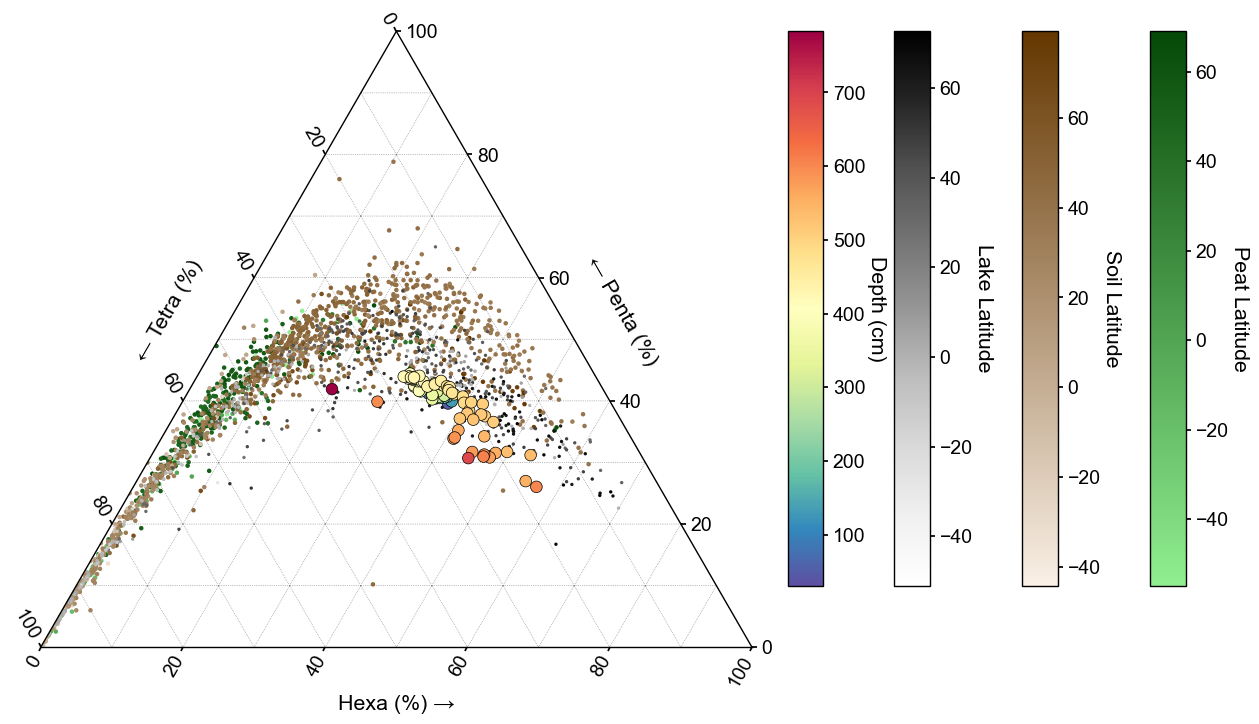

In [188]:
#This makes a ternary diagram with your dataset, colored by a defined variable and all modern calibration data (lakes, peat, soils) colored by latitude.
fig = plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

#values for triangular grid
t, l, r = get_triangular_grid()

t0, l0, r0 = (brGDGT_df_tern['penta'],brGDGT_df_tern['tetra'],brGDGT_df_tern['hexa'])
length = brGDGT_df_tern['depth']

t1, l1, r1 = (globalLakeGDGT_df_tern['penta'],globalLakeGDGT_df_tern['tetra'],globalLakeGDGT_df_tern['hexa'])
lat0 = globalLakeGDGT_df_tern['Latitude']

t2, l2, r2 = (globalSoilGDGT_df_tern['penta'],globalSoilGDGT_df_tern['tetra'],globalSoilGDGT_df_tern['hexa'])
lat1 = globalSoilGDGT_df_tern['Latitude']
# Define your two endpoint colors
soilcolor1 = 'linen'  # Replace with your desired color
soilcolor2 =  '#653700' # Replace with your desired color

# Create a colormap with two endpoint colors
soil_colormap = LinearSegmentedColormap.from_list('custom_colormap', [soilcolor1, soilcolor2], N=256)

t3, l3, r3 = (globalPeatGDGT_df_tern['penta'],globalPeatGDGT_df_tern['tetra'],globalPeatGDGT_df_tern['hexa'])
lat2 = globalPeatGDGT_df_tern['Latitude']
# Define your two endpoint colors
peatcolor1 = 'lightgreen'  # Replace with your desired color
peatcolor2 =  '#054907' # Replace with your desired color

# Create a colormap with two endpoint colors
peat_colormap = LinearSegmentedColormap.from_list('custom_colormap', [peatcolor1, peatcolor2], N=256)

####globalPeatGDGT_df_tern

ax = plt.subplot(projection="ternary", ternary_sum=100.0)

#Set wording and position of axis labels
ax.set_tlabel("← Penta (%)")
ax.set_llabel("← Tetra (%)")
ax.set_rlabel("Hexa (%) →")
ax.taxis.set_label_position('tick1')
ax.laxis.set_label_position('tick1')
ax.raxis.set_label_position('tick1')

#plot triangular grid
ax.triplot(t, l, r, linewidth=0.5,color='gray',linestyle=':')

ax.grid()

#plot data
peat=ax.scatter(t3, l3, r3, c=lat2,cmap=peat_colormap, s=5)
soil=ax.scatter(t2, l2, r2, c=lat1,cmap=soil_colormap, s=5)
lk=ax.scatter(t1, l1, r1, c=lat0,cmap='Greys',s=2)
#soil=ax.scatter(t2, l2, r2, c=lat1,cmap='copper', vmin=0.2, vmax=1,s=2)#,linewidth=0)#,edgecolors='k')
this = ax.scatter(t0, l0, r0, c=length,cmap='Spectral_r',linewidth=0.5,edgecolors='k', s=70)

cax0 = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
colorbar0 = fig.colorbar(this, cax=cax0)
colorbar0.set_label("Depth (cm)", rotation=270, va="baseline")

cax1 = ax.inset_axes([1.20, 0.1, 0.05, 0.9], transform=ax.transAxes)
colorbar1 = fig.colorbar(lk, cax=cax1)
colorbar1.set_label("Lake Latitude", rotation=270, va="baseline")

cax2 = ax.inset_axes([1.38, 0.1, 0.05, 0.9], transform=ax.transAxes)
colorbar2 = fig.colorbar(soil, cax=cax2)
colorbar2.set_label("Soil Latitude", rotation=270, va="baseline")

cax3 = ax.inset_axes([1.56, 0.1, 0.05, 0.9], transform=ax.transAxes)
colorbar3 = fig.colorbar(peat, cax=cax3)
colorbar3.set_label("Peat Latitude", rotation=270, va="baseline")

# Save the figure with higher resolution
plt.savefig("ternary.png", dpi=300, bbox_inches="tight")  # Adjust the file name and dpi as needed

plt.show()

In [190]:
#Make all the GDGT peak data into a single dataframe for math/plotting with Seaborn

# Merge the DataFrames one by one
allGDGT_df = isoGDGT_df.merge(brGDGT_df, on=['depth', 'ageMedian'])#, suffixes=('_iso0', '_iso1'))
#allGDGT_df = allGDGT_df.drop_duplicates(subset=['midpointdepth'])

# Rename the columns
allGDGT_df = allGDGT_df.rename(columns={'paleoData_values_iso0': 'iso0','paleoData_values_iso1': 'iso1',
                                        'paleoData_values_iso2': 'iso2','paleoData_values_iso3': 'iso3',
                                        'paleoData_values_cren': 'cren','paleoData_values_crenreg': 'crenreg',
                                        'paleoData_values_Ia': 'Ia','paleoData_values_Ib': 'Ib','paleoData_values_Ic': 'Ic',
                                        'paleoData_values_IIa5': 'IIa5','paleoData_values_IIa6': 'IIa6','paleoData_values_IIb5': 'IIb5',
                                        'paleoData_values_IIb6': 'IIb6','paleoData_values_IIc5': 'IIc5','paleoData_values_IIc6': 'IIc6',
                                        'paleoData_values_IIIa5': 'IIIa5','paleoData_values_IIIa6': 'IIIa6','paleoData_values_IIIb5': 'IIIb5',
                                        'paleoData_values_IIIb6': 'IIIb6','paleoData_values_IIIc5': 'IIIc5','paleoData_values': 'IIIc6',
                                       })

allGDGT_df

,depth,ageMedian,iso0,iso1,iso2,iso3,cren,crenreg,Ia,Ib,Ic,IIa5,IIa6,IIb5,IIb6,IIc5,IIc6,IIIa5,IIIa6,IIIb5,IIIb6,IIIc5,IIIc6
0,31,-11.412127,47.218094,17.505662,7.890179,2.132162,69.218668,1.807291,288.154483,28.865409,19.259662,335.814792,155.002716,34.664931,20.923988,15.411931,0.0,322.874755,119.267860,4.973508,8.211976,2.151634,0.0
1,51,305.387259,45.747964,18.631168,7.430010,1.947957,74.321253,1.743994,229.528552,28.023781,16.789533,262.107330,145.434968,33.503122,19.151383,12.752581,0.0,315.296696,117.190950,4.923324,8.354353,1.988641,0.0
2,79,993.553336,36.132858,13.497739,5.998618,1.600536,53.163983,1.373765,180.716426,21.998042,13.642702,200.730753,105.896889,26.490647,14.164487,10.917638,0.0,205.555673,79.224825,3.732182,4.994045,1.372069,0.0
3,107,1373.173196,40.608870,16.304175,7.217866,1.917600,64.267780,1.746514,198.041918,30.998704,18.531656,221.937937,120.862751,36.122102,19.029971,15.014530,0.0,255.697618,90.617786,4.954241,7.763893,2.247240,0.0
4,133,1831.760492,38.800245,16.806220,7.775232,1.953298,65.120194,1.813521,152.896231,32.227179,19.149820,184.083348,109.817844,38.072782,18.912691,15.415600,0.0,249.053495,82.021980,5.062319,8.317815,2.583408,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,597,NaN,0.977853,0.000000,0.000000,0.000000,0.000000,0.000000,7.238010,0.819293,0.000000,7.827173,1.468559,0.523525,0.000000,0.000000,0.0,5.168030,1.156579,0.427440,0.000000,0.000000,0.0
82,603,NaN,0.909434,0.000000,0.000000,0.000000,0.000000,0.000000,4.224430,0.000000,0.000000,4.333673,1.464521,0.565069,0.000000,0.000000,0.0,8.425016,2.958987,1.490584,0.000000,0.971541,0.0
83,609,NaN,0.761103,0.000000,0.000000,0.000000,0.246739,0.000000,4.004754,0.535803,0.000000,4.240219,1.523315,0.549480,0.000000,0.000000,0.0,6.188073,1.922718,0.880314,0.000000,0.545044,0.0
84,689,NaN,0.554516,0.000000,0.000000,0.000000,0.325770,0.000000,3.373506,0.410417,0.000000,3.464783,1.038971,0.234050,0.000000,0.000000,0.0,5.790699,0.891336,0.224105,0.000000,0.000000,0.0


In [204]:
allGDGT_df

,depth,ageMedian,iso0,iso1,iso2,iso3,cren,crenreg,Ia,Ib,Ic,IIa5,IIa6,IIb5,IIb6,IIc5,IIc6,IIIa5,IIIa6,IIIb5,IIIb6,IIIc5,IIIc6
0,31,-11.412127,47.218094,17.505662,7.890179,2.132162,69.218668,1.807291,288.154483,28.865409,19.259662,335.814792,155.002716,34.664931,20.923988,15.411931,0.0,322.874755,119.267860,4.973508,8.211976,2.151634,0.0
1,51,305.387259,45.747964,18.631168,7.430010,1.947957,74.321253,1.743994,229.528552,28.023781,16.789533,262.107330,145.434968,33.503122,19.151383,12.752581,0.0,315.296696,117.190950,4.923324,8.354353,1.988641,0.0
2,79,993.553336,36.132858,13.497739,5.998618,1.600536,53.163983,1.373765,180.716426,21.998042,13.642702,200.730753,105.896889,26.490647,14.164487,10.917638,0.0,205.555673,79.224825,3.732182,4.994045,1.372069,0.0
3,107,1373.173196,40.608870,16.304175,7.217866,1.917600,64.267780,1.746514,198.041918,30.998704,18.531656,221.937937,120.862751,36.122102,19.029971,15.014530,0.0,255.697618,90.617786,4.954241,7.763893,2.247240,0.0
4,133,1831.760492,38.800245,16.806220,7.775232,1.953298,65.120194,1.813521,152.896231,32.227179,19.149820,184.083348,109.817844,38.072782,18.912691,15.415600,0.0,249.053495,82.021980,5.062319,8.317815,2.583408,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,597,NaN,0.977853,0.000000,0.000000,0.000000,0.000000,0.000000,7.238010,0.819293,0.000000,7.827173,1.468559,0.523525,0.000000,0.000000,0.0,5.168030,1.156579,0.427440,0.000000,0.000000,0.0
82,603,NaN,0.909434,0.000000,0.000000,0.000000,0.000000,0.000000,4.224430,0.000000,0.000000,4.333673,1.464521,0.565069,0.000000,0.000000,0.0,8.425016,2.958987,1.490584,0.000000,0.971541,0.0
83,609,NaN,0.761103,0.000000,0.000000,0.000000,0.246739,0.000000,4.004754,0.535803,0.000000,4.240219,1.523315,0.549480,0.000000,0.000000,0.0,6.188073,1.922718,0.880314,0.000000,0.545044,0.0
84,689,NaN,0.554516,0.000000,0.000000,0.000000,0.325770,0.000000,3.373506,0.410417,0.000000,3.464783,1.038971,0.234050,0.000000,0.000000,0.0,5.790699,0.891336,0.224105,0.000000,0.000000,0.0


In [205]:
Raberg_CI

,depth,ageMedian,Ia,Ib,Ic,IIa5,IIa6,IIb5,IIb6,IIc5,IIc6,IIIa5,IIIa6,IIIb5,IIIb6,IIIc5,IIIc6
0,31,-11.412127,0.856890,0.085838,0.057273,0.597728,0.275895,0.061701,0.037243,0.027432,0.0,0.705768,0.260706,0.010872,0.017950,0.004703,0.0
1,51,305.387259,0.836652,0.102149,0.061199,0.554197,0.307506,0.070839,0.040494,0.026964,0.0,0.704174,0.261731,0.010996,0.018658,0.004441,0.0
2,79,993.553336,0.835269,0.101675,0.063056,0.560387,0.295636,0.073955,0.039543,0.030479,0.0,0.697085,0.268669,0.012657,0.016936,0.004653,0.0
3,107,1373.173196,0.799936,0.125211,0.074854,0.537423,0.292669,0.087470,0.046081,0.036358,0.0,0.707753,0.250824,0.013713,0.021490,0.006220,0.0
4,133,1831.760492,0.748489,0.157765,0.093746,0.502545,0.299801,0.103938,0.051631,0.042084,0.0,0.717653,0.236348,0.014587,0.023968,0.007444,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,597,NaN,0.898317,0.101683,0.000000,0.797125,0.149559,0.053316,0.000000,0.000000,0.0,0.765402,0.171293,0.063305,0.000000,0.000000,0.0
82,603,NaN,1.000000,0.000000,0.000000,0.681046,0.230153,0.088802,0.000000,0.000000,0.0,0.608475,0.213705,0.107653,0.000000,0.070167,0.0
83,609,NaN,0.881996,0.118004,0.000000,0.671663,0.241298,0.087039,0.000000,0.000000,0.0,0.648907,0.201624,0.092313,0.000000,0.057156,0.0
84,689,NaN,0.891537,0.108463,0.000000,0.731306,0.219294,0.049401,0.000000,0.000000,0.0,0.838486,0.129064,0.032450,0.000000,0.000000,0.0


In [207]:
#calculate brGDGT indices
# Create a new DataFrame
GDGT_indices = pd.DataFrame()
GDGT_indices['depth'] = allGDGT_df['depth']
GDGT_indices['ageMedian'] = allGDGT_df['ageMedian']
#GDGT_indices['PC1'] = PC1_norm
#GDGT_indices['PC2'] = PC2_norm
GDGT_indices['%hexa'] = brGDGT_df_tern['hexa']
GDGT_indices["MBT'5Me"] = (allGDGT_df['Ia']+allGDGT_df['Ib']+allGDGT_df['Ic'])/(allGDGT_df['Ia']+allGDGT_df['Ib']+allGDGT_df['Ic']+allGDGT_df['IIa5']+allGDGT_df['IIb5']+allGDGT_df['IIc5']+allGDGT_df['IIIa5'])
GDGT_indices["CBT'5Me"] = -np.log10((allGDGT_df['Ib']+allGDGT_df['IIb5'])/(allGDGT_df['Ia']+(allGDGT_df['IIa5'])))
GDGT_indices['cald/cren'] = allGDGT_df['iso0']/allGDGT_df['cren']
GDGT_indices['HP5'] = allGDGT_df['IIIa5']/(allGDGT_df['IIa5']+allGDGT_df['IIIa5'])
GDGT_indices['BIT'] = (allGDGT_df['Ia']+allGDGT_df['IIa5']+allGDGT_df['IIIa5'])/(allGDGT_df['Ia']+allGDGT_df['IIa5']+allGDGT_df['IIIa5']+allGDGT_df['cren'])
GDGT_indices['IR'] = (allGDGT_df['IIa6']+allGDGT_df['IIb6']+allGDGT_df['IIc6']+allGDGT_df['IIIa6']+allGDGT_df['IIIb6']+allGDGT_df['IIIc6'])/(allGDGT_df['IIa6']+allGDGT_df['IIb6']+allGDGT_df['IIc6']+allGDGT_df['IIIa6']+allGDGT_df['IIIb6']+allGDGT_df['IIIc6']+allGDGT_df['IIa5']+allGDGT_df['IIb5']+allGDGT_df['IIc5']+allGDGT_df['IIIa5']+allGDGT_df['IIIb5']+allGDGT_df['IIIc5'])
GDGT_indices['fC'] = 0.5*((allGDGT_df['Ib']+allGDGT_df['IIb5']+allGDGT_df['IIb6']+allGDGT_df['IIIb5']+allGDGT_df['IIIb6']+2*(allGDGT_df['Ic']+allGDGT_df['IIc5']+allGDGT_df['IIc6']+allGDGT_df['IIIc5']+allGDGT_df['IIIc6']))/(allGDGT_df['Ia']+allGDGT_df['Ib']+allGDGT_df['Ic']+allGDGT_df['IIa5']+allGDGT_df['IIa6']+allGDGT_df['IIb5']+allGDGT_df['IIb6']+allGDGT_df['IIIa5']+allGDGT_df['IIIa6']+allGDGT_df['IIIb5']+allGDGT_df['IIIb6']+allGDGT_df['IIc5']+allGDGT_df['IIc6']+allGDGT_df['IIIc5']+allGDGT_df['IIIc6']))
GDGT_indices['conductivity'] = np.exp(6.62+8.87*Raberg_CI['Ib']+5.12*Raberg_CI['IIa6']**2+10.64*Raberg_CI['IIa5']**2-8.59*Raberg_CI['IIa5']-4.32*Raberg_CI['IIIa6']**2-5.32*Raberg_CI['IIIa5']**2-142.67*Raberg_CI['IIIb5']**2)
#GDGT_indices['TEX'] = (allGDGT_df['iso2']+allGDGT_df['iso3']+allGDGT_df['crenreg'])/(allGDGT_df['iso1']+allGDGT_df['iso2']+allGDGT_df['iso3']+allGDGT_df['crenreg'])
#GDGT_indices['%isoGDGT2'] = (allGDGT_df['iso2'])/(allGDGT_df['iso1']+allGDGT_df['iso2']+allGDGT_df['iso3']+allGDGT_df['crenreg'])
#GDGT_indices['fcrenreg'] = (allGDGT_df['crenreg'])/(allGDGT_df['cren']+allGDGT_df['crenreg'])



GDGT_indices

/Users/elizabeth/anaconda3/envs/pyleo/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,depth,ageMedian,%hexa,MBT'5Me,CBT'5Me,cald/cren,HP5,BIT,IR,fC,conductivity
0,31,-11.412127,0.337480,0.321784,0.992182,0.682158,0.490177,0.931876,0.297662,0.063178,32.383317
1,51,305.387259,0.374675,0.305503,0.902579,0.615544,0.546059,0.915664,0.315120,0.065695,35.389196
2,79,993.553336,0.339161,0.327788,0.895794,0.679649,0.505938,0.916953,0.312796,0.070876,35.770205
3,107,1373.173196,0.353566,0.318895,0.796371,0.631870,0.535340,0.913145,0.307749,0.083408,38.951391
4,133,1831.760492,0.378197,0.295663,0.680648,0.595825,0.575000,0.899993,0.307105,0.096386,46.443720
...,...,...,...,...,...,...,...,...,...,...,...
81,597,NaN,0.274155,0.373438,1.049957,inf,0.397688,1.000000,0.158415,0.035939,41.876013
82,603,NaN,0.566679,0.240733,1.180276,inf,0.660336,1.000000,0.218884,0.081828,8.633808
83,609,NaN,0.467694,0.292593,0.880646,3.084644,0.593393,0.983192,0.217427,0.074932,28.895674
84,689,NaN,0.447641,0.285074,1.025747,1.702171,0.625651,0.974853,0.165778,0.028149,26.423856


In [208]:
#calculate iso GDGT indices
# Create a new DataFrame
isoGDGT_indices = pd.DataFrame()
isoGDGT_indices['depth'] = allGDGT_df['depth']
isoGDGT_indices['ageMedian'] = allGDGT_df['ageMedian']
isoGDGT_indices['BIT'] = (allGDGT_df['Ia']+allGDGT_df['IIa5']+allGDGT_df['IIIa5'])/(allGDGT_df['Ia']+allGDGT_df['IIa5']+allGDGT_df['IIIa5']+allGDGT_df['cren'])
isoGDGT_indices['cald/cren'] = allGDGT_df['iso0']/allGDGT_df['cren']
isoGDGT_indices['% GDGT-2'] = (allGDGT_df['iso2'])/(allGDGT_df['iso1']+allGDGT_df['iso2']+allGDGT_df['iso3']+allGDGT_df['crenreg'])
isoGDGT_indices['% cren iso'] = (allGDGT_df['crenreg'])/(allGDGT_df['cren']+allGDGT_df['crenreg'])
isoGDGT_indices['TEX'] = (allGDGT_df['iso2']+allGDGT_df['iso3']+allGDGT_df['crenreg'])/(allGDGT_df['iso1']+allGDGT_df['iso2']+allGDGT_df['iso3']+allGDGT_df['crenreg'])
#calculate TEX for all samples
isoGDGT_indices['TEX'] = isoGDGT_indices['TEX']
#remove TEX values for samples where cren-prime == 0
isoGDGT_indices.loc[isoGDGT_indices['% cren iso'] == 0, 'TEX'] = np.nan
isoGDGT_indices['[GDGT-3]'] = (allGDGT_df['iso3'])

isoGDGT_indices[60:85]

,depth,ageMedian,BIT,cald/cren,% GDGT-2,% cren iso,TEX,[GDGT-3]
60,495,10213.413572,0.892540,1.338807,0.256635,0.009597,0.322285,0.419115
61,499,10385.926722,0.918461,1.805586,0.276312,0.000000,NaN,0.547209
62,507,10756.496103,0.893144,1.070748,0.282018,0.000000,NaN,0.000000
63,509,10876.245338,0.890810,1.194033,0.292691,0.000000,NaN,0.000000
64,511,10987.783069,0.879492,0.984012,0.296631,0.000000,NaN,0.000000
65,513,11059.592702,0.876067,0.989765,0.268869,0.000000,NaN,0.000000
66,517,NaN,0.871511,0.873482,0.289502,0.000000,NaN,0.000000
67,521,NaN,0.872363,1.009437,0.000000,0.000000,NaN,0.000000
68,527,NaN,0.877640,1.086438,0.000000,0.000000,NaN,0.000000
69,533,NaN,0.881988,1.012544,0.000000,0.000000,NaN,0.000000


In [209]:
isoGDGT_plot = isoGDGT_indices.drop(isoGDGT_indices.index[67:86])
isoGDGT_plot

,depth,ageMedian,BIT,cald/cren,% GDGT-2,% cren iso,TEX,[GDGT-3]
0,31,-11.412127,0.931876,0.682158,0.268965,0.025445,0.403256,2.132162
1,51,305.387259,0.915664,0.615544,0.249722,0.022928,0.373808,1.947957
2,79,993.553336,0.916953,0.679649,0.266953,0.025189,0.399317,1.600536
3,107,1373.173196,0.913145,0.631870,0.265498,0.026457,0.400277,1.917600
4,133,1831.760492,0.899993,0.595825,0.274275,0.027094,0.407152,1.953298
...,...,...,...,...,...,...,...,...
62,507,10756.496103,0.893144,1.070748,0.282018,0.000000,NaN,0.000000
63,509,10876.245338,0.890810,1.194033,0.292691,0.000000,NaN,0.000000
64,511,10987.783069,0.879492,0.984012,0.296631,0.000000,NaN,0.000000
65,513,11059.592702,0.876067,0.989765,0.268869,0.000000,NaN,0.000000


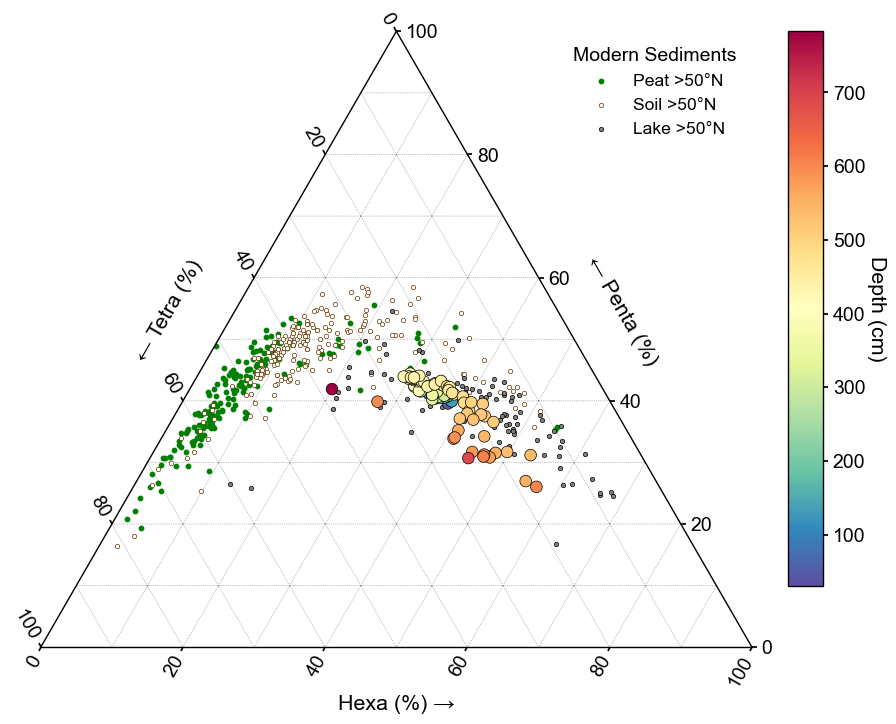

In [212]:
#This makes a ternary diagram with your dataset, colored by a defined variable and modern calibration data (lakes, peat, soils) from within a given latitude range.
fig = plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

minlat=50
#values for triangular grid
t, l, r = get_triangular_grid()

t0, l0, r0 = (brGDGT_df_tern['penta'],brGDGT_df_tern['tetra'],brGDGT_df_tern['hexa'])
#length = brGDGT_df_tern['ageMedian']/1000 #this is to color the samples by age
length = brGDGT_df_tern['depth'] #this is to color the samples by a GDGT index

t1, l1, r1 = (globalLakeGDGT_df_tern['penta'],globalLakeGDGT_df_tern['tetra'],globalLakeGDGT_df_tern['hexa'])
lat0 = globalLakeGDGT_df_tern['Latitude']

# Filter lake latitudes
lat0 = lat0[(globalLakeGDGT_df_tern['Latitude'] >= minlat)]
t1 = t1[(globalLakeGDGT_df_tern['Latitude'] >= minlat)]
l1 = l1[(globalLakeGDGT_df_tern['Latitude'] >= minlat)]
r1 = r1[(globalLakeGDGT_df_tern['Latitude'] >= minlat)]

t2, l2, r2 = (globalSoilGDGT_df_tern['penta'],globalSoilGDGT_df_tern['tetra'],globalSoilGDGT_df_tern['hexa'])
lat1 = globalSoilGDGT_df_tern['Latitude']
# Define your two endpoint colors
soilcolor1 = 'linen'  # Replace with your desired color
soilcolor2 =  '#653700' # Replace with your desired color

# Create a colormap with two endpoint colors
soil_colormap = LinearSegmentedColormap.from_list('custom_colormap', [soilcolor1, soilcolor2], N=256)

# Filter soil latitudes
lat1 = lat1[(globalSoilGDGT_df_tern['Latitude'] >= minlat)]
t2 = t2[(globalSoilGDGT_df_tern['Latitude'] >= minlat)]
l2 = l2[(globalSoilGDGT_df_tern['Latitude'] >= minlat)]
r2 = r2[(globalSoilGDGT_df_tern['Latitude'] >= minlat)]

t3, l3, r3 = (globalPeatGDGT_df_tern['penta'],globalPeatGDGT_df_tern['tetra'],globalPeatGDGT_df_tern['hexa'])
lat2 = globalPeatGDGT_df_tern['Latitude']
# Define your two endpoint colors
peatcolor1 = 'lightgreen'  # Replace with your desired color
peatcolor2 =  '#054907' # Replace with your desired color

# Create a colormap with two endpoint colors
peat_colormap = LinearSegmentedColormap.from_list('custom_colormap', [peatcolor1, peatcolor2], N=256)

# Filter soil latitudes
lat2 = lat2[(globalPeatGDGT_df_tern['Latitude'] >= minlat)]
t3 = t3[(globalPeatGDGT_df_tern['Latitude'] >= minlat)]
l3 = l3[(globalPeatGDGT_df_tern['Latitude'] >= minlat)]
r3 = r3[(globalPeatGDGT_df_tern['Latitude'] >= minlat)]

ax = plt.subplot(projection="ternary", ternary_sum=100.0)

#Set wording and position of axis labels
ax.set_tlabel("← Penta (%)")
ax.set_llabel("← Tetra (%)")
ax.set_rlabel("Hexa (%) →")
ax.taxis.set_label_position('tick1')
ax.laxis.set_label_position('tick1')
ax.raxis.set_label_position('tick1')

#plot triangular grid
ax.triplot(t, l, r, linewidth=0.5,color='gray',linestyle=':')

ax.grid()

#plot data
#below is single colors
peat=ax.scatter(t3, l3, r3, c='green', s=10, label='Peat >50°N')
soil=ax.scatter(t2, l2, r2, c='white',linewidth=0.5,edgecolors='#653700', s=10, label='Soil >50°N')
lk=ax.scatter(t1, l1, r1, c='gray',linewidth=0.5,edgecolors='k',s=10, label='Lake >50°N')
#below has color maps
#peat=ax.scatter(t3, l3, r3, c=lat2,cmap=peat_colormap, s=5)
#soil=ax.scatter(t2, l2, r2, c=lat1,cmap=soil_colormap, s=5)
#lk=ax.scatter(t1, l1, r1, c=lat0,cmap='Greys',s=5)
this = ax.scatter(t0, l0, r0, c=length,cmap='Spectral_r',linewidth=0.5,edgecolors='k', s=70)

cax0 = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
colorbar0 = fig.colorbar(this, cax=cax0)
#colorbar0.set_label("Age (kyr)", rotation=270, va="baseline") #colorbar label for Age
colorbar0.set_label("Depth (cm)", rotation=270, va="baseline") #colorbar label for GDGT index of choice

#the code below adds a legend if using single colors for the modern data plots
ax.legend(title='Modern Sediments')

#activate below code if using colormaps for modern data
#cax1 = ax.inset_axes([1.20, 0.1, 0.05, 0.9], transform=ax.transAxes)
#colorbar1 = fig.colorbar(lk, cax=cax1)
#colorbar1.set_label("Lake Latitude", rotation=270, va="baseline")

#cax2 = ax.inset_axes([1.38, 0.1, 0.05, 0.9], transform=ax.transAxes)
#colorbar2 = fig.colorbar(soil, cax=cax2)
#colorbar2.set_label("Soil Latitude", rotation=270, va="baseline")

#cax3 = ax.inset_axes([1.56, 0.1, 0.05, 0.9], transform=ax.transAxes)
#colorbar3 = fig.colorbar(peat, cax=cax3)
#colorbar3.set_label("Peat Latitude", rotation=270, va="baseline")

# Save the figure with higher resolution
plt.savefig("ternary.png", dpi=300, bbox_inches="tight")  # Adjust the file name and dpi as needed

plt.show()

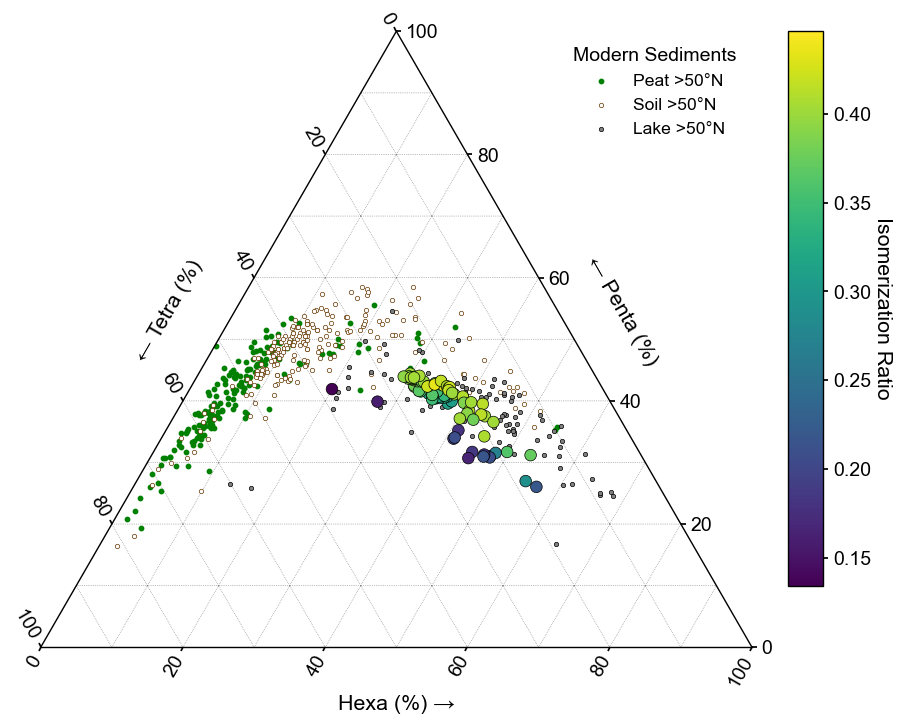

In [210]:
#This makes a ternary diagram with your dataset, colored by a defined variable and modern calibration data (lakes, peat, soils) from within a given latitude range.
fig = plt.figure(figsize=(10, 8))  # Adjust the width and height as needed

minlat=50
#values for triangular grid
t, l, r = get_triangular_grid()

t0, l0, r0 = (brGDGT_df_tern['penta'],brGDGT_df_tern['tetra'],brGDGT_df_tern['hexa'])
#length = brGDGT_df_tern['ageMedian']/1000 #this is to color the samples by age
length = GDGT_indices['IR'] #this is to color the samples by a GDGT index

t1, l1, r1 = (globalLakeGDGT_df_tern['penta'],globalLakeGDGT_df_tern['tetra'],globalLakeGDGT_df_tern['hexa'])
lat0 = globalLakeGDGT_df_tern['Latitude']

# Filter lake latitudes
lat0 = lat0[(globalLakeGDGT_df_tern['Latitude'] >= minlat)]
t1 = t1[(globalLakeGDGT_df_tern['Latitude'] >= minlat)]
l1 = l1[(globalLakeGDGT_df_tern['Latitude'] >= minlat)]
r1 = r1[(globalLakeGDGT_df_tern['Latitude'] >= minlat)]

t2, l2, r2 = (globalSoilGDGT_df_tern['penta'],globalSoilGDGT_df_tern['tetra'],globalSoilGDGT_df_tern['hexa'])
lat1 = globalSoilGDGT_df_tern['Latitude']
# Define your two endpoint colors
soilcolor1 = 'linen'  # Replace with your desired color
soilcolor2 =  '#653700' # Replace with your desired color

# Create a colormap with two endpoint colors
soil_colormap = LinearSegmentedColormap.from_list('custom_colormap', [soilcolor1, soilcolor2], N=256)

# Filter soil latitudes
lat1 = lat1[(globalSoilGDGT_df_tern['Latitude'] >= minlat)]
t2 = t2[(globalSoilGDGT_df_tern['Latitude'] >= minlat)]
l2 = l2[(globalSoilGDGT_df_tern['Latitude'] >= minlat)]
r2 = r2[(globalSoilGDGT_df_tern['Latitude'] >= minlat)]

t3, l3, r3 = (globalPeatGDGT_df_tern['penta'],globalPeatGDGT_df_tern['tetra'],globalPeatGDGT_df_tern['hexa'])
lat2 = globalPeatGDGT_df_tern['Latitude']
# Define your two endpoint colors
peatcolor1 = 'lightgreen'  # Replace with your desired color
peatcolor2 =  '#054907' # Replace with your desired color

# Create a colormap with two endpoint colors
peat_colormap = LinearSegmentedColormap.from_list('custom_colormap', [peatcolor1, peatcolor2], N=256)

# Filter soil latitudes
lat2 = lat2[(globalPeatGDGT_df_tern['Latitude'] >= minlat)]
t3 = t3[(globalPeatGDGT_df_tern['Latitude'] >= minlat)]
l3 = l3[(globalPeatGDGT_df_tern['Latitude'] >= minlat)]
r3 = r3[(globalPeatGDGT_df_tern['Latitude'] >= minlat)]

ax = plt.subplot(projection="ternary", ternary_sum=100.0)

#Set wording and position of axis labels
ax.set_tlabel("← Penta (%)")
ax.set_llabel("← Tetra (%)")
ax.set_rlabel("Hexa (%) →")
ax.taxis.set_label_position('tick1')
ax.laxis.set_label_position('tick1')
ax.raxis.set_label_position('tick1')

#plot triangular grid
ax.triplot(t, l, r, linewidth=0.5,color='gray',linestyle=':')

ax.grid()

#plot data
#below is single colors
peat=ax.scatter(t3, l3, r3, c='green', s=10, label='Peat >50°N')
soil=ax.scatter(t2, l2, r2, c='white',linewidth=0.5,edgecolors='#653700', s=10, label='Soil >50°N')
lk=ax.scatter(t1, l1, r1, c='gray',linewidth=0.5,edgecolors='k',s=10, label='Lake >50°N')
#below has color maps
#peat=ax.scatter(t3, l3, r3, c=lat2,cmap=peat_colormap, s=5)
#soil=ax.scatter(t2, l2, r2, c=lat1,cmap=soil_colormap, s=5)
#lk=ax.scatter(t1, l1, r1, c=lat0,cmap='Greys',s=5)
this = ax.scatter(t0, l0, r0, c=length,cmap='viridis',linewidth=0.5,edgecolors='k', s=70)

cax0 = ax.inset_axes([1.05, 0.1, 0.05, 0.9], transform=ax.transAxes)
colorbar0 = fig.colorbar(this, cax=cax0)
#colorbar0.set_label("Age (kyr)", rotation=270, va="baseline") #colorbar label for Age
colorbar0.set_label("Isomerization Ratio", rotation=270, va="baseline") #colorbar label for GDGT index of choice

#the code below adds a legend if using single colors for the modern data plots
ax.legend(title='Modern Sediments')

#activate below code if using colormaps for modern data
#cax1 = ax.inset_axes([1.20, 0.1, 0.05, 0.9], transform=ax.transAxes)
#colorbar1 = fig.colorbar(lk, cax=cax1)
#colorbar1.set_label("Lake Latitude", rotation=270, va="baseline")

#cax2 = ax.inset_axes([1.38, 0.1, 0.05, 0.9], transform=ax.transAxes)
#colorbar2 = fig.colorbar(soil, cax=cax2)
#colorbar2.set_label("Soil Latitude", rotation=270, va="baseline")

#cax3 = ax.inset_axes([1.56, 0.1, 0.05, 0.9], transform=ax.transAxes)
#colorbar3 = fig.colorbar(peat, cax=cax3)
#colorbar3.set_label("Peat Latitude", rotation=270, va="baseline")

# Save the figure with higher resolution
plt.savefig("ternary.png", dpi=300, bbox_inches="tight")  # Adjust the file name and dpi as needed

plt.show()

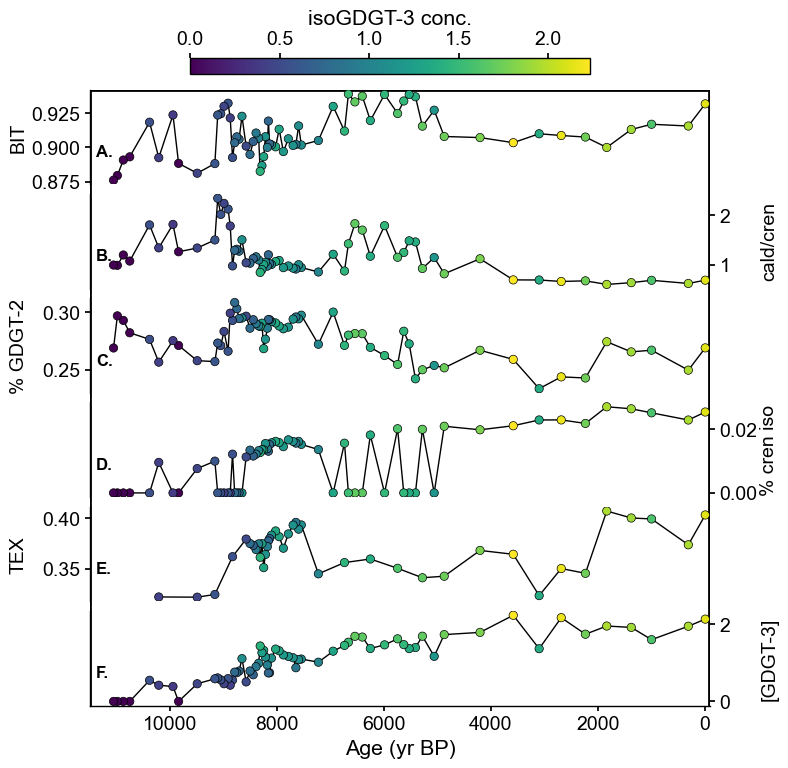

In [224]:
# Replace 'inf' values with NaN
isoGDGT_indices.replace([np.inf, -np.inf], np.nan, inplace=True)
isoGDGT_plot = isoGDGT_indices.drop(isoGDGT_indices.index[67:86])
# Create a figure and axes
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(8, 8), sharex=True)
# Reverse the x-axis for the entire plot
fig.gca().invert_xaxis()

# Extract the values for color mapping
clr = isoGDGT_plot.iloc[:, 7]

# Create a colormap based on column 7 values
cmap = plt.cm.viridis  # You can choose a different colormap if desired
norm = plt.Normalize(vmin=clr.min(), vmax=clr.max())

# Loop through the indices and create subplots with scatter plot and lines
for i, column in enumerate(isoGDGT_plot.columns[2:8], start=2):
    # Extract x and y values
    x = isoGDGT_plot['ageMedian']
    y = isoGDGT_plot[column]
#set the background of the subplots to be seethrough so lines and rectangles drawn later will appear
    axes[i-2].patch.set_alpha(0)
    axes[i-2].set_xlim(11500,-100)
    axes[i-2].grid(visible=False)
    # Find indices of non-NaN values
    #valid_indices = ~np.isnan(x) & ~np.isnan(y)
    valid_indices = ~np.isnan(x.values) & ~np.isnan(y.values) & ~np.isnan(clr)

    # Plot scatter plot
    sc = axes[i-2].scatter(
        x[valid_indices],
        y[valid_indices],
        label=column,  # Use the column name as the label
        marker='o',
        edgecolor='k',
        linewidths=0.5,
        c=clr[valid_indices],  # Use clr for color mapping
        cmap=cmap,  # You can choose a different colormap if desired
        norm=norm,
        zorder=2  
    )

    # Plot lines connecting the dots
    axes[i-2].plot(
        x[valid_indices],
        y[valid_indices],
        color='k',  # Match line color with marker color
        linestyle='-',
        linewidth=1,
        zorder=1 
    )

    axes[i-2].set_ylabel(column, fontsize=14)  # Add y-axis label
     
    # Add subplot text with the column name
    # axes[i-2].text(
    #     0.98, 0.1,  # Adjust the text position if needed
    #     column,
    #     transform=axes[i-2].transAxes,
    #     ha='right',
    #     va='bottom',
    #     fontsize=14,
    #     bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'),  # Add a semi-transparent white background
    # )
    
    # Remove x-axis ticks and lines for all subplots except the bottom one
    if i < 7:
        axes[i-2].xaxis.set_ticks_position('none')
        axes[i-2].spines['bottom'].set_visible(False)

    # Alternate y-axis ticks and labels left-right-left-right
    if i % 2 == 0:
        axes[i-2].yaxis.tick_left()
        axes[i-2].yaxis.set_label_coords(-0.1, 0.5)
    else:
        axes[i-2].yaxis.tick_right()
        axes[i-2].yaxis.set_label_coords(1.11, 0.5)

# Assuming axs is a 2D array containing your subplots
for i, ax in enumerate(axes):
    # Calculate the position for the label in each subplot
    x_pos = 0.01  # Adjust the x-coordinate as needed
    y_pos = 0.42   # Adjust the y-coordinate as needed

    # Add the label to the upper left corner of each subplot
    ax.text(x_pos, y_pos, f"{chr(65 + i)}.", transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')

# Set common labels and title
#fig.suptitle('isoGDGT indices', y=0.95)
axes[-1].set_xlabel('Age (yr BP)')

# Add colorbar to the top
#first add an axes for the colorbar, syntax is (left,bottom,width,height)
cbaxes = fig.add_axes([0.25, 0.9, 0.5, 0.02])  
 
# now draw the colorbar and label it
cb = plt.colorbar(sc, cax = cbaxes, orientation = 'horizontal')
# Set the ticks and label position to the top
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
# Add the colorbar label
cb.set_label("isoGDGT-3 conc.")

ax_full = fig.add_subplot(111,zorder=-1)
ax_full.set_axis_off()
ax_full.set_xlim(11500,-100)

#draw a rectangle to highlight specific time span in the plot
#ax_full.axvspan(11500,11400,color='gray',zorder=-1,alpha=0.2)

#draw black lines around the plot
ax_full.axvline(11500,0,1,color='k',zorder=1)
ax_full.axvline(-80,0,1,color='k',zorder=1)
ax_full.axhline(1,11500,-100,color='k',zorder=1)

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.1)

# Save the figure with higher resolution
plt.savefig("isoGDGT_indices.png", dpi=300, bbox_inches="tight")  # Adjust the file name and dpi as needed

# Show the plot
plt.show()

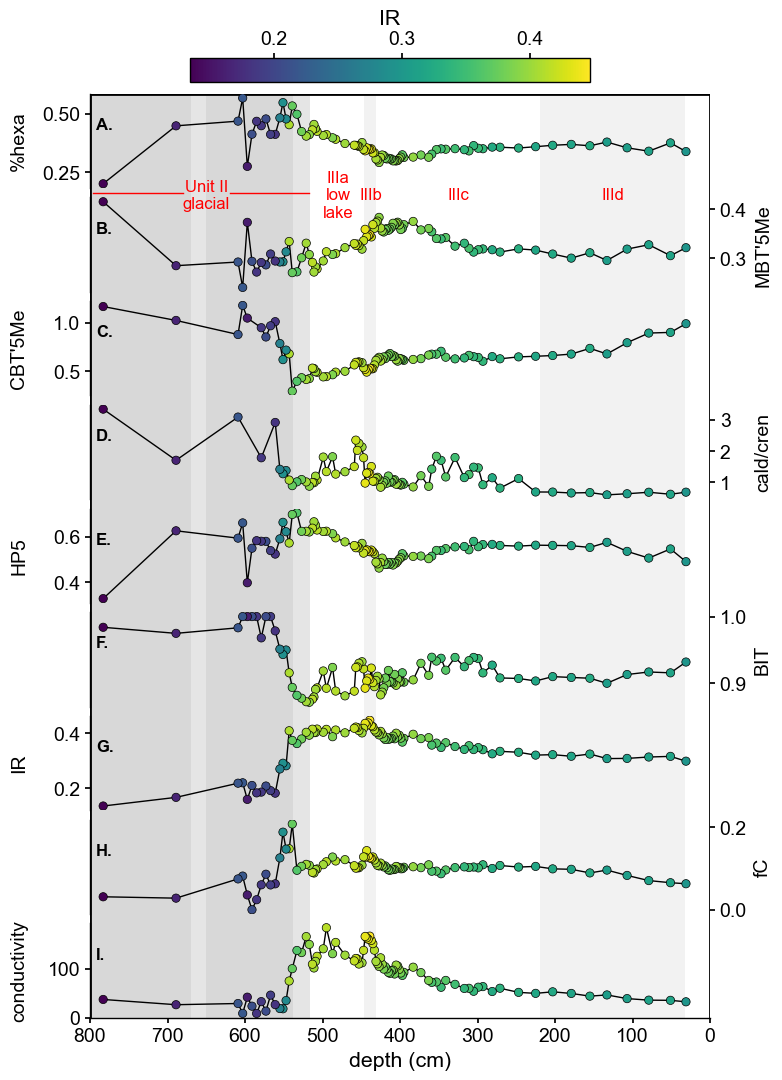

In [246]:
# Replace 'inf' values with NaN
GDGT_indices.replace([np.inf, -np.inf], np.nan, inplace=True)

# Create a figure and axes
fig, axes = plt.subplots(nrows=9, ncols=1, figsize=(8, 12), sharex=True)
# Reverse the x-axis for the entire plot
fig.gca().invert_xaxis()

# Extract the values for color mapping
clr = GDGT_indices.iloc[:, 8]

# Loop through the indices and create subplots with scatter plot and lines
for i, column in enumerate(GDGT_indices.columns[2:13], start=2):
    # Extract x and y values
    x = GDGT_indices['depth']
    y = GDGT_indices[column]
#set the background of the subplots to be seethrough so lines and rectangles drawn later will appear
    axes[i-2].patch.set_alpha(0)
    axes[i-2].set_xlim(800,0)
    axes[i-2].grid(visible=False)
    # Find indices of non-NaN values
    valid_indices = ~np.isnan(x) & ~np.isnan(y)

    # Plot scatter plot
    sc = axes[i-2].scatter(
        x[valid_indices],
        y[valid_indices],
        label=column,  # Use the column name as the label
        marker='o',
        edgecolor='k',
        linewidths=0.5,
        c=clr[valid_indices],  # Use clr for color mapping
        cmap='viridis',  # You can choose a different colormap if desired
        zorder=2  
    )

    # Plot lines connecting the dots
    axes[i-2].plot(
        x[valid_indices],
        y[valid_indices],
        color='k',  # Match line color with marker color
        linestyle='-',
        linewidth=1,
        zorder=1 
    )
    

    axes[i-2].set_ylabel(column, fontsize=14)  # Add y-axis label
     
    # Add subplot text with the column name
    # axes[i-2].text(
    #     0.8, 0.9,  # Adjust the text position if needed
    #     column,
    #     transform=axes[i-2].transAxes,
    #     ha='left',
    #     va='top',
    #     fontsize=14,
    #     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),  # Add a semi-transparent white background
    # )
    
    # Remove x-axis ticks and lines for all subplots except the bottom one
    if i < 10:
        axes[i-2].xaxis.set_ticks_position('none')
        axes[i-2].spines['bottom'].set_visible(False)

    # Alternate y-axis ticks and labels left-right-left-right
    if i % 2 == 0:
        axes[i-2].yaxis.tick_left()
        axes[i-2].yaxis.set_label_coords(-0.1, 0.5)
    else:
        axes[i-2].yaxis.tick_right()
        axes[i-2].yaxis.set_label_coords(1.1, 0.5)

# Assuming axs is a 2D array containing your subplots
for i, ax in enumerate(axes):
    # Calculate the position for the label in each subplot
    x_pos = 0.01  # Adjust the x-coordinate as needed
    y_pos = 0.75   # Adjust the y-coordinate as needed

    # Add the label to the upper left corner of each subplot
    ax.text(x_pos, y_pos, f"{chr(65 + i)}.", transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')

# Set common labels and title
#fig.suptitle('GDGT indices', y=0.9)
axes[-1].set_xlabel('depth (cm)')

# Add colorbar to the top
#first add an axes for the colorbar, syntax is (left,bottom,width,height)
cbaxes = fig.add_axes([0.25, 0.89, 0.5, 0.02])  
 
# now draw the colorbar and label it
cb = plt.colorbar(sc, cax = cbaxes, orientation = 'horizontal')
# Set the ticks and label position to the top
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
# Add the colorbar label
cb.set_label('IR')

ax_full = fig.add_subplot(111,zorder=-1)
ax_full.set_axis_off()
ax_full.set_xlim(800,0)

#draw a rectangle to highlight specific time span in the plot
#this code draws several rectangles to highlight changes in lithology
ax_full.axvspan(670,800,facecolor='gray',edgecolor=None,zorder=-1,alpha=0.3)
ax_full.axvspan(650,670,facecolor='gray',edgecolor=None,zorder=-1,alpha=0.2)
ax_full.axvspan(538,650,facecolor='gray',edgecolor=None,zorder=-1,alpha=0.3)
ax_full.axvspan(516,538,facecolor='gray',edgecolor=None,zorder=-1,alpha=0.2)
ax_full.axvspan(431,447,facecolor='gray',edgecolor=None,zorder=-1,alpha=0.1)
ax_full.axvspan(32,220,facecolor='gray',edgecolor=None,zorder=-1,alpha=0.1)

# These lines highlight the span of a specific lithological unit
ax_full.axhline(.893, xmin=0.005, xmax=.15,color='red',linewidth=1,zorder=10)
ax_full.axhline(.893, xmin=0.225, xmax=.354,color='red',linewidth=1,zorder=10)
#add labels to each lithological unit
ax_full.text(650, .89, 'Unit II\nglacial', fontsize=12, color='red', ha='center', va='center')
ax_full.text(480, .89, 'IIIa\nlow\nlake', fontsize=12, color='red', ha='center', va='center')
ax_full.text(438, .89, 'IIIb', fontsize=12, color='red', ha='center', va='center')
ax_full.text(325, .89, 'IIIc', fontsize=12, color='red', ha='center', va='center')
ax_full.text(125, .89, 'IIId', fontsize=12, color='red', ha='center', va='center')

#draw black lines around the plot
ax_full.axvline(800,0,1,color='k',zorder=1)
ax_full.axvline(0,0,1,color='k',zorder=1)
ax_full.axhline(1,800,0,color='k',zorder=1)

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.1)

# Save the figure with higher resolution
plt.savefig("GDGT_indices.png", dpi=300, bbox_inches="tight")  # Adjust the file name and dpi as needed

# Show the plot
plt.show()

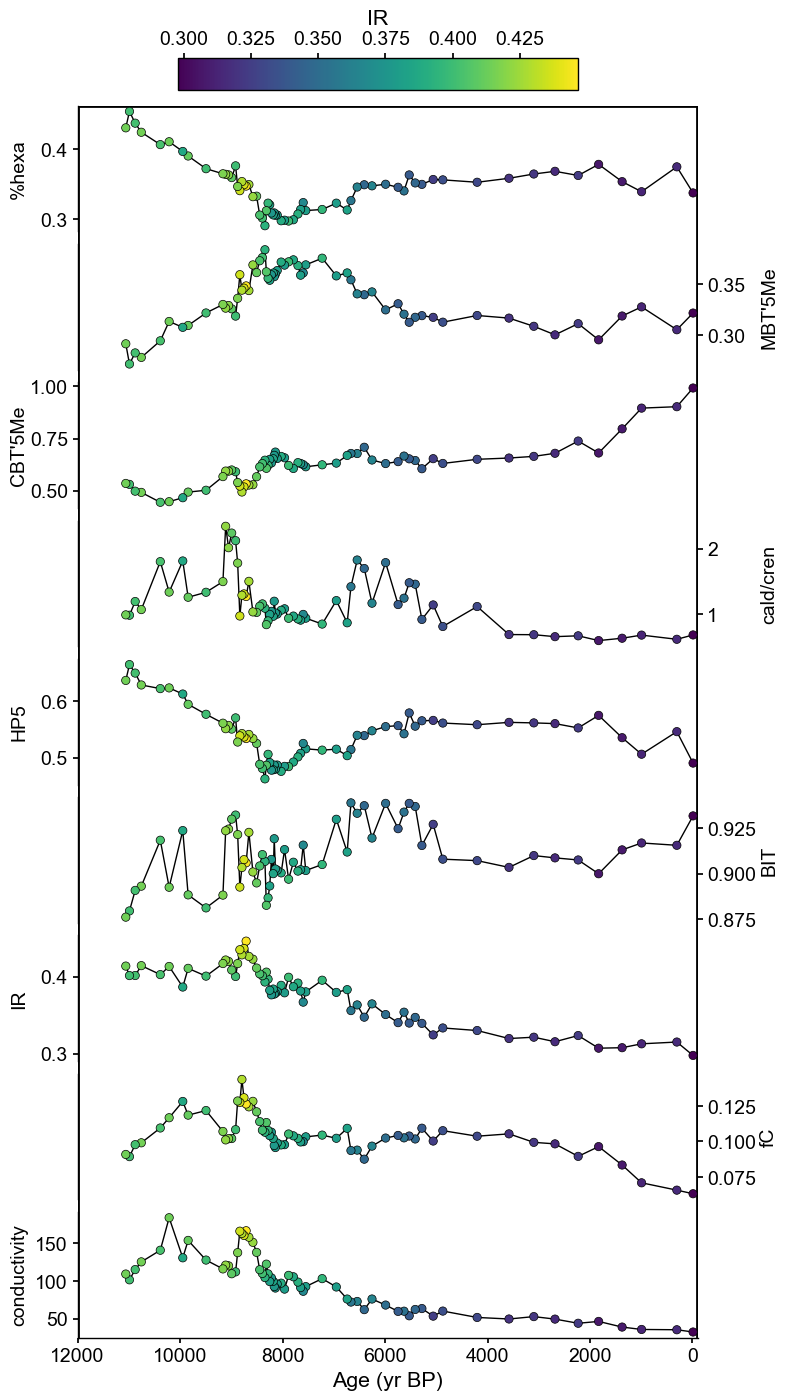

In [251]:
# Replace 'inf' values with NaN
GDGT_indices.replace([np.inf, -np.inf], np.nan, inplace=True)

# Create a figure and axes
fig, axes = plt.subplots(nrows=9, ncols=1, figsize=(8, 16), sharex=True)
# Reverse the x-axis for the entire plot
fig.gca().invert_xaxis()

# Extract the values for color mapping
clr = GDGT_indices.iloc[:, 8]

# Loop through the indices and create subplots with scatter plot and lines
for i, column in enumerate(GDGT_indices.columns[2:13], start=2):
    # Extract x and y values
    x = GDGT_indices['ageMedian']
    y = GDGT_indices[column]
#set the background of the subplots to be seethrough so lines and rectangles drawn later will appear
    axes[i-2].patch.set_alpha(0)
    axes[i-2].set_xlim(12000,-100)
    axes[i-2].grid(visible=False)
    # Find indices of non-NaN values
    valid_indices = ~np.isnan(x) & ~np.isnan(y)

    # Plot scatter plot
    sc = axes[i-2].scatter(
        x[valid_indices],
        y[valid_indices],
        label=column,  # Use the column name as the label
        marker='o',
        edgecolor='k',
        linewidths=0.5,
        c=clr[valid_indices],  # Use clr for color mapping
        cmap='viridis',  # You can choose a different colormap if desired
        zorder=2  
    )

    # Plot lines connecting the dots
    axes[i-2].plot(
        x[valid_indices],
        y[valid_indices],
        color='k',  # Match line color with marker color
        linestyle='-',
        linewidth=1,
        zorder=1 
    )

    axes[i-2].set_ylabel(column, fontsize=14)  # Add y-axis label
     
    
    # Add subplot text with the column name
    # axes[i-2].text(
    #     0.8, 0.9,  # Adjust the text position if needed
    #     column,
    #     transform=axes[i-2].transAxes,
    #     ha='left',
    #     va='top',
    #     fontsize=14,
    #     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),  # Add a semi-transparent white background
    # )
    
    # Remove x-axis ticks and lines for all subplots except the bottom one
    if i < 10:
        axes[i-2].xaxis.set_ticks_position('none')
        axes[i-2].spines['bottom'].set_visible(False)

    # Alternate y-axis ticks and labels left-right-left-right
    if i % 2 == 0:
        axes[i-2].yaxis.tick_left()
        axes[i-2].yaxis.set_label_coords(-0.08, 0.5)
    else:
        axes[i-2].yaxis.tick_right()
        axes[i-2].yaxis.set_label_coords(1.13, 0.5)

# Set common labels and title
#fig.suptitle('GDGT indices', y=0.9)
axes[-1].set_xlabel('Age (yr BP)')

# Add colorbar to the top
#first add an axes for the colorbar, syntax is (left,bottom,width,height)
cbaxes = fig.add_axes([0.25, 0.89, 0.5, 0.02])  
 
# now draw the colorbar and label it
cb = plt.colorbar(sc, cax = cbaxes, orientation = 'horizontal')
# Set the ticks and label position to the top
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
# Add the colorbar label
cb.set_label('IR')

ax_full = fig.add_subplot(111,zorder=-1)
ax_full.set_axis_off()
ax_full.set_xlim(12000,-100)

#draw a rectangle to highlight specific time span in the plot
#ax_full.axvspan(15500,11400,color='gray',zorder=-1,alpha=0.2)

#draw black lines around the plot
ax_full.axvline(12000,0,1,color='k',zorder=1)
ax_full.axvline(-80,0,1,color='k',zorder=1)
ax_full.axhline(1,12000,-100,color='k',zorder=1)

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.1)

# Show the plot
plt.show()

In [265]:
#cladocera=pd.read_csv('Imandra_cladocera.csv')

In [272]:
# Must create two variables, one for the returned 'ensemble' and one for the returned 'age_axis'
cladocera_ens, cladocera = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='cladocera plankt.Faunal',
                                           depth_name='depth',
                                           val_unit='percent'
                                           )



Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.32it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...


In [270]:
# Must create two variables, one for the returned 'ensemble' and one for the returned 'age_axis'
cladocera_ens, cladocera = getlipd('Imandra.Holtzman.2024.lpd',
                                           paleoData_variableName='littoral-benthic gr.Faunal',
                                           depth_name='depth',
                                           val_unit='percent'
                                           )



Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


Loaded..
             datasetName                                      ensembleTable  \
0  Imandra.Holtzman.2024  http://linked.earth/lipd/Imandra.Holtzman.2024...   

  ensembleVariableName                             ensembleVariableValues  \
0          ageEnsemble  [[-66.6889, -66.9619, -68.4464, -69.3591, -70....   

  ensembleVariableUnits ensembleDepthName  \
0                 yr BP             depth   

                                 ensembleDepthValues ensembleDepthUnits notes  
0  [0.0, 5.21108910891089, 10.4221782178218, 15.6...                 cm  None  
Extracting timeseries from dataset: Imandra.Holtzman.2024 ...


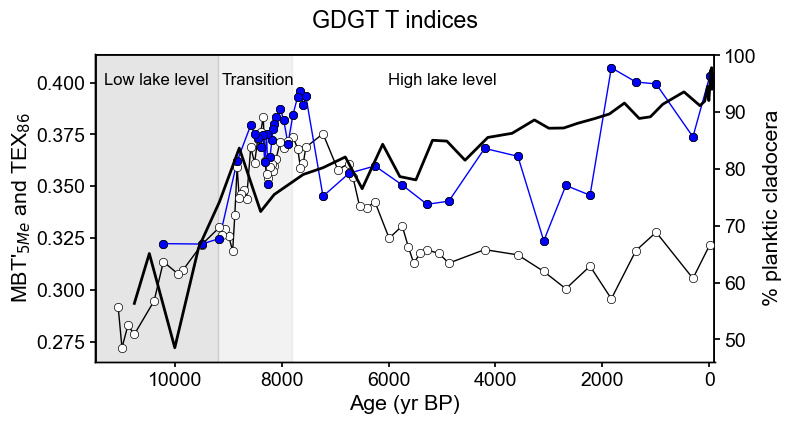

In [308]:
# Replace 'inf' values with NaN
GDGT_indices.replace([np.inf, -np.inf], np.nan, inplace=True)

# Create a figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
# Reverse the x-axis for the entire plot
fig.gca().invert_xaxis()

    # Plot scatter plot
axes.scatter(
    GDGT_indices['ageMedian'],
    GDGT_indices["MBT'5Me"],
    marker='o',
    edgecolor='k',
    linewidths=0.5,
    c='w',  # Use clr for color mapping
    #cmap='viridis',  # You can choose a different colormap if desired
    zorder=2  
)

    # Plot lines connecting the dots
axes.plot(
    GDGT_indices['ageMedian'],
    GDGT_indices["MBT'5Me"],
    color='k',  # Match line color with marker color
    linestyle='-',
    linewidth=1,
    zorder=1 
)

axes.scatter(
    isoGDGT_plot['ageMedian'],
    isoGDGT_plot['TEX'],
    marker='o',
    edgecolor='k',
    linewidths=0.5,
    c='w',  # Use clr for color mapping
    #cmap='viridis',  # You can choose a different colormap if desired
    zorder=2  
)


x=isoGDGT_plot['ageMedian']
y=isoGDGT_plot['TEX']
# Find indices of non-NaN values
valid_TEX = ~np.isnan(x) & ~np.isnan(y)
axes.scatter(
    x[valid_TEX],
    y[valid_TEX],
    label=column,  # Use the column name as the label
    marker='o',
    edgecolor='k',
    linewidths=0.5,
    c='b',  # Use clr for color mapping
    zorder=2  
)

#     # Plot lines connecting the dots
axes.plot(
    x[valid_TEX],
    y[valid_TEX],
    color='b',  # Match line color with marker color
    linestyle='-',
    linewidth=1,
    zorder=1 
)
#set the background of the subplots to be seethrough so lines and rectangles drawn later will appear
axes.patch.set_alpha(0)
axes.set_xlim(11500,-100)
#axes.set_ylim(0.25,0.42)
#axes.yaxis.tick_left()
#axes.yaxis.set_label_coords(1.11, 0.5)
axes.grid(visible=False)
axes.set_ylabel("MBT'$_{5Me}$ and TEX$_{86}$",c='k')

    # Alternate y-axis ticks and labels left-right-left-right
axes.yaxis.tick_left()
axes.yaxis.set_label_coords(-0.1, 0.5)

    # Plot scatter plot
ax_twin = axes.twinx()
ax_twin.plot(cladocera.ageMedian, cladocera.paleoData_values,c='k',zorder=0)

ax_twin.set_ylabel('% planktic cladocera',c='k')

ax_twin.grid(visible=False)

# Set common labels and title
fig.suptitle('GDGT T indices', y=0.99)
axes.set_xlabel('Age (yr BP)')
 
ax_full = fig.add_subplot(111,zorder=-1)
ax_full.set_axis_off()
ax_full.set_xlim(11500,-100)

#draw a rectangle to highlight specific time span in the plot
ax_full.axvspan(11500,9200,color='gray',edgecolor=None,zorder=-1,alpha=0.2)
ax_full.axvspan(9190,7800,color='gray',edgecolor=None,zorder=-1,alpha=0.1)

#draw black lines around the plot
ax_full.axvline(11500,0,1,color='k',zorder=1)
ax_full.axvline(-80,0,1,color='k',zorder=1)
ax_full.axhline(1,11500,-100,color='k',zorder=1)

ax_full.text(10350, .9, 'Low lake level', fontsize=12, color='black', ha='center')
ax_full.text(8450, .9, 'Transition', fontsize=12, color='black', ha='center')
ax_full.text(5000, .9, 'High lake level', fontsize=12, color='black', ha='center')

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.1)

# Save the figure with higher resolution
plt.savefig("TEX_MBT_lakelevel_full.png", dpi=300, bbox_inches="tight")  # Adjust the file name and dpi as needed

# Show the plot
plt.show()

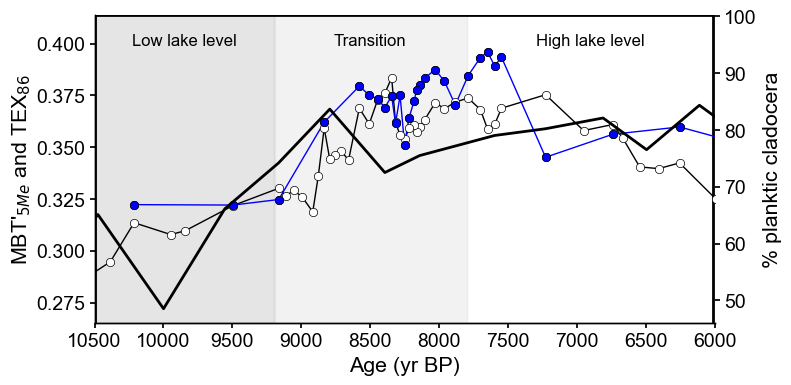

In [309]:
# Replace 'inf' values with NaN
GDGT_indices.replace([np.inf, -np.inf], np.nan, inplace=True)

# Create a figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
# Reverse the x-axis for the entire plot
fig.gca().invert_xaxis()

    # Plot scatter plot
axes.scatter(
    GDGT_indices['ageMedian'],
    GDGT_indices["MBT'5Me"],
    marker='o',
    edgecolor='k',
    linewidths=0.5,
    c='w',  # Use clr for color mapping
    #cmap='viridis',  # You can choose a different colormap if desired
    zorder=2  
)

    # Plot lines connecting the dots
axes.plot(
    GDGT_indices['ageMedian'],
    GDGT_indices["MBT'5Me"],
    color='k',  # Match line color with marker color
    linestyle='-',
    linewidth=1,
    zorder=1 
)

axes.scatter(
    isoGDGT_plot['ageMedian'],
    isoGDGT_plot['TEX'],
    marker='o',
    edgecolor='k',
    linewidths=0.5,
    c='w',  # Use clr for color mapping
    #cmap='viridis',  # You can choose a different colormap if desired
    zorder=2  
)


x=isoGDGT_plot['ageMedian']
y=isoGDGT_plot['TEX']
# Find indices of non-NaN values
valid_TEX = ~np.isnan(x) & ~np.isnan(y)
axes.scatter(
    x[valid_TEX],
    y[valid_TEX],
    label=column,  # Use the column name as the label
    marker='o',
    edgecolor='k',
    linewidths=0.5,
    c='b',  # Use clr for color mapping
    zorder=2  
)

#     # Plot lines connecting the dots
axes.plot(
    x[valid_TEX],
    y[valid_TEX],
    color='b',  # Match line color with marker color
    linestyle='-',
    linewidth=1,
    zorder=1 
)
#set the background of the subplots to be seethrough so lines and rectangles drawn later will appear
axes.patch.set_alpha(0)
axes.set_xlim(10500,6000)
#axes.set_ylim(0.25,0.42)
#axes.yaxis.tick_left()
#axes.yaxis.set_label_coords(1.11, 0.5)
axes.grid(visible=False)
axes.set_ylabel("MBT'$_{5Me}$ and TEX$_{86}$",c='k')

    # Alternate y-axis ticks and labels left-right-left-right
axes.yaxis.tick_left()
axes.yaxis.set_label_coords(-0.1, 0.5)

    # Plot scatter plot
ax_twin = axes.twinx()
ax_twin.plot(cladocera.ageMedian, cladocera.paleoData_values,c='k',zorder=0)

ax_twin.set_ylabel('% planktic cladocera',c='k')

ax_twin.grid(visible=False)

# Set common labels and title
#fig.suptitle('GDGT T indices', y=0.99)
axes.set_xlabel('Age (yr BP)')
 
ax_full = fig.add_subplot(111,zorder=-1)
ax_full.set_axis_off()
ax_full.set_xlim(10500,6000)

#draw a rectangle to highlight specific time span in the plot
ax_full.axvspan(10500,9200,color='gray',edgecolor=None,zorder=-1,alpha=0.2)
ax_full.axvspan(9190,7800,color='gray',edgecolor=None,zorder=-1,alpha=0.1)

#draw black lines around the plot
ax_full.axvline(10500,0,1,color='k',zorder=1)
ax_full.axvline(6010,0,1,color='k',zorder=1)
ax_full.axhline(1,10500,-100,color='k',zorder=1)

ax_full.text(9850, .9, 'Low lake level', fontsize=12, color='black', ha='center')
ax_full.text(8500, .9, 'Transition', fontsize=12, color='black', ha='center')
ax_full.text(6900, .9, 'High lake level', fontsize=12, color='black', ha='center')

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.1)

# Save the figure with higher resolution
plt.savefig("TEX_MBT_lakelevel_zoom.png", dpi=300, bbox_inches="tight")  # Adjust the file name and dpi as needed

# Show the plot
plt.show()

In [355]:
#calculate GDGT indices
# Create a new DataFrame
GDGT_temps = pd.DataFrame()
GDGT_temps['depth'] = allGDGT_df['depth']
GDGT_temps['ageMedian'] = allGDGT_df['ageMedian']
GDGT_temps['Russell MBT'] = -1.21+(GDGT_indices["MBT'5Me"]*32.42)
GDGT_temps['Russell SFS'] = 23.81-31.02*brGDGT_df_norm['IIIa5']-51.59*brGDGT_df_norm['IIb6']-24.70*brGDGT_df_norm['IIa5']+68.80*brGDGT_df_norm['Ib']
GDGT_temps['Zhao MBT'] = -1.82+(GDGT_indices["MBT'5Me"]*56.06)
GDGT_temps['Raberg Meth Set'] = (92.9+63.84*(Raberg_Meth['Ib']/(Raberg_Meth['Ib']+Raberg_Meth['IIb5']+Raberg_Meth['IIIb5']))**2
                                   -130.51*(Raberg_Meth['Ib']/(Raberg_Meth['Ib']+Raberg_Meth['IIb5']+Raberg_Meth['IIIb5']))
                                   -28.77*(Raberg_Meth['IIa5']/(Raberg_Meth['Ia']+Raberg_Meth['IIa5']+Raberg_Meth['IIIa5']))**2
                                   -72.28*(Raberg_Meth['IIb5']/(Raberg_Meth['Ib']+Raberg_Meth['IIb5']+Raberg_Meth['IIIb5']))**2
                                   -5.88*(Raberg_Meth['IIc5']/(Raberg_Meth['Ic']+Raberg_Meth['IIc5']+Raberg_Meth['IIIc5']))**2
                                   +20.89*(Raberg_Meth['IIIa5']/(Raberg_Meth['Ia']+Raberg_Meth['IIa5']+Raberg_Meth['IIIa5']))**2
                                   -40.54*(Raberg_Meth['IIIa5']/(Raberg_Meth['Ia']+Raberg_Meth['IIa5']+Raberg_Meth['IIIa5']))
                                   -80.47*(Raberg_Meth['IIIb5']/(Raberg_Meth['Ib']+Raberg_Meth['IIb5']+Raberg_Meth['IIIb5']))
                                  )
GDGT_temps['Raberg Full Set'] = (-8.06+37.52*brGDGT_df_norm['Ia']
                                 -266.83*brGDGT_df_norm['Ib']**2
                                 +133.42*brGDGT_df_norm['Ib']
                                 +100.85*brGDGT_df_norm['IIa6']**2
                                 +58.15*brGDGT_df_norm['IIIa6']**2
                                 +12.79*brGDGT_df_norm['IIIa5']
                                )
GDGT_temps['Powers TEX'] = -14.0+(isoGDGT_indices['TEX']*55.2)

#brGDGT_df_norm
#brGDGT_df
GDGT_temps


,depth,ageMedian,Russell MBT,Russell SFS,Zhao MBT,Raberg Meth Set,Raberg Full Set,Powers TEX
0,31,-11.412127,9.222252,10.971393,16.219237,8.847324,7.450711,8.259729
1,51,305.387259,8.694396,10.994972,15.306479,8.230618,7.555623,6.634207
2,79,993.553336,9.416891,11.673785,16.555802,8.858923,7.946435,8.042307
3,107,1373.173196,9.128572,11.809209,16.057247,8.403146,8.082632,8.095265
4,133,1831.760492,8.375400,11.788641,14.754877,7.604164,7.928828,8.474783
...,...,...,...,...,...,...,...,...
81,597,NaN,10.896849,11.739642,19.114916,NaN,10.280317,NaN
82,603,NaN,6.594568,8.733123,11.675499,12.244877,4.052175,NaN
83,609,NaN,8.275870,11.067099,14.582773,4.355648,7.592705,NaN
84,689,NaN,8.032113,8.450069,14.161272,NaN,8.956762,NaN


In [353]:
#export key GDGT results to use elsewhere
GDGT_temps.to_csv("Imandra_GDGT_temps.csv")
GDGT_indices.to_csv("Imandra_GDGT_indices.csv")
isoGDGT_indices.to_csv("Imandra_isoGDGT_indices.csv")
brGDGTconc.to_csv("Imandra_brGDGT_concentration.csv")

/var/folders/5z/d18gfz9n2d1ffs0620jtvcxm0000gn/T/ipykernel_81239/1196926351.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


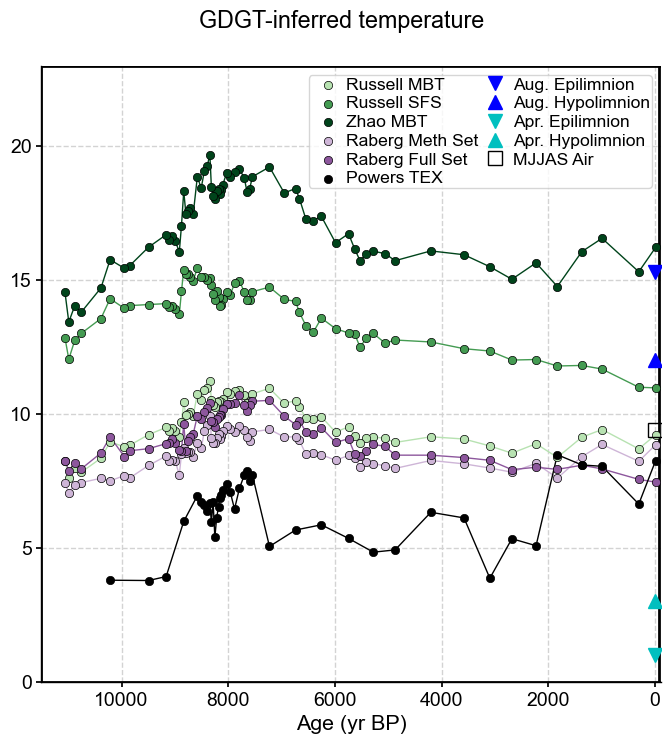

In [354]:
#This code makes a single plot showing all the different temperature calibration-inferred values

mod_lake_t_aug=15.3 #Kaverina, I., & Pogozheva, V. (2005)
mod_lake_t_apr=1 #Kaverina, I., & Pogozheva, V. (2005)
mod_lakehypo_t_aug=12 #Kaverina, I., & Pogozheva, V. (2005)
mod_lakehypo_t_apr=3 #Kaverina, I., & Pogozheva, V. (2005)
mod_air_t_MJJAS=9.4 #NOAA GHCN, Monchegorsk station


# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(8, 8))

# Reverse the x-axis for the entire plot
ax.invert_xaxis()

# Extract the values for color mapping
# Generate equally spaced colors from 'PRGn' colormap excluding the white color
colors = [cm.PRGn(i / (7 - 1)) for i in range(7)]

column_colors = {'Russell MBT': colors[4], 'Russell SFS': colors[5], 'Zhao MBT': colors[6], 'Raberg Meth Set': colors[2], 'Raberg Full Set': colors[1],'Powers TEX':'black'}

# Loop through the indices and create a scatter plot and lines
for i, column in enumerate(GDGT_temps.columns[2:8], start=2):
    # Extract x and y values
    x = GDGT_temps['ageMedian']
    y = GDGT_temps[column]
    ax.set_xlim(11500,-120)
    ax.set_ylim(0,23)

    # Find indices of non-NaN values
    valid_indices = ~np.isnan(x) & ~np.isnan(y)

    # Plot scatter plot
    ax.scatter(
        x[valid_indices],
        y[valid_indices],
        label=column,  # Use the column name as the label
        marker='o',
        edgecolor='k',
        linewidths=0.5,
        c=column_colors[column],  # Use column_colors for color mapping
        zorder=2  
    )

    # Plot lines connecting the dots
    ax.plot(
        x[valid_indices],
        y[valid_indices],
        color=column_colors[column],  # Use column_colors for color mapping
        linestyle='-',
        linewidth=1,
        zorder=1 
    )


# Set common labels and title
fig.suptitle('GDGT-inferred temperature', y=0.95)
ax.set_xlabel('Age (yr BP)')

# Draw a rectangle to highlight a specific time span in the plot
#ax.axvspan(11500, 11400, color='gray', zorder=-1, alpha=0.2)

# Draw black lines around the plot
ax.axvline(11500, 0, 1, color='k', zorder=1)
ax.axvline(-80, 0, 1, color='k', zorder=1)
ax.axhline(0, 11500, -80, color='k', zorder=1)
ax.axhline(23, 11500, -80, color='k', zorder=1)

# Draw modern temperature dots at age=0
ax.plot(0, mod_lake_t_aug, 'bv', label='Aug. Epilimnion',markersize=10)  # use this to plot a single point
ax.plot(0, mod_lakehypo_t_aug, 'b^', label='Aug. Hypolimnion',markersize=10)  # use this to plot a single point
ax.plot(0, mod_lake_t_apr, 'cv', label='Apr. Epilimnion',markersize=10)  # use this to plot a single point
ax.plot(0, mod_lakehypo_t_apr, 'c^', label='Apr. Hypolimnion',markersize=10)  # use this to plot a single point
ax.plot(0, mod_air_t_MJJAS, 'ks', label='MJJAS Air',fillstyle='none',markersize=10)  # use this to plot a single point

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(0.99, 0.99),labelspacing=0.2,frameon=True,borderpad=0.1,borderaxespad=0.2,
          handletextpad=0,ncols=2,columnspacing=0)

# Adjust layout for better spacing
fig.subplots_adjust(hspace=0.1)

# Save the figure with higher resolution
plt.savefig("GDGT_Temps.png", dpi=300, bbox_inches="tight")  # Adjust the file name and dpi as needed

# Show the plot
plt.show()
